Import and function declarations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# data preprocess
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
# resampling
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
# feature selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, RFE
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from collections import OrderedDict
from tabulate import tabulate
from sklearn.linear_model import Lasso
from sklearn import metrics
! pip install SequentialFeatureSelector
! pip install Scikit-learn==0.20.4 -i https://pypi.tuna.tsinghua.edu.cn/simple
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EXS
from sklearn.tree import DecisionTreeClassifier
# scaling & PCA
#! pip install -U scikit-learn scipy matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# Modeling
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBRFClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
import seaborn as sns

def Preprocess(data):
    # remove columns that has too many zeros
    data =raw
    for key in data.columns:
      if (data[key] == 0).sum() /len(data[key]) > 0.95 or key == 'bank_name' or key == 'year':
        print('removing', key)
        data = data.drop(key,axis=1)

    # convert 'new_date' to from str to int
    data[['date', 'month', 'year']] = data['new_date'].str.split('/', expand=True).astype(float)
    data = data.drop('new_date', axis = 1)
    # missing values
    imp = IterativeImputer()
    data_1 = imp.fit_transform(data.values)
    data_1 = pd.DataFrame(data_1)
    data_1.columns = data.columns
    # split into train, test
    train_data = data_1[data['year']<=2010]
    test_data = data_1[data['year']>2010]

    return train_data, test_data

# Resampling
def SmoteEnn(data):

    X_features = data.drop("failure", axis=1).values
    y_failures = data['failure'].values # target
    pos_num = len(y_failures[y_failures == 1])
    neg_num = len(y_failures[y_failures == 0])
    print("Before resample, Positive: {}, Negative: {}".format(pos_num, neg_num))
    print("Ratio(neg / pos): {}".format(neg_num / pos_num))
    
    smote_enn = SMOTEENN(random_state=0)
    X_resampled, y_resampled = smote_enn.fit_resample(X_features, y_failures)

    pos_num = len(y_resampled[y_resampled == 1])
    neg_num = len(y_resampled[y_resampled == 0])
    print("After resample, Positive: {}, Negative: {}".format(pos_num, neg_num))
    print("Ratio(neg / pos): {}".format(neg_num / pos_num))

    X_features = data.columns.drop('failure')
    data_st = pd.DataFrame(X_resampled.T,X_features).T
    data_st['failure'] = y_resampled.tolist()
    return data_st

def SmoteTomek(data):
    X_features = data.drop("failure", axis=1).values
    y_failures = data['failure'].values # target
    pos_num = len(y_failures[y_failures == 1])
    neg_num = len(y_failures[y_failures == 0])
    print("Before resample, Positive: {}, Negative: {}".format(pos_num, neg_num))
    print("Ratio(neg / pos): {}".format(neg_num / pos_num))
    
    smt = SMOTETomek(random_state = 0)
    X_resampled, y_resampled = smt.fit_resample(X_features, y_failures)
    pos_num = len(y_resampled[y_resampled == 1])
    neg_num = len(y_resampled[y_resampled == 0])
    print("After resample, Positive: {}, Negative: {}".format(pos_num, neg_num))
    print("Ratio(neg / pos): {}".format(neg_num / pos_num))

    X_features = data.columns.drop('failure')
    data_st = pd.DataFrame(X_resampled.T,X_features).T
    data_st['failure'] = y_resampled.tolist()
    return data_st

# Feature Selections
def wrapper(data):
    sample_data = data.sample(n=10000,random_state=123,axis=0)
    X = sample_data.drop("failure", axis=1).values
    y = sample_data['failure'].values # target
    m = DecisionTreeClassifier(min_samples_leaf=20)
    sbs = SFS(m, 
              k_features=4, 
              forward=False,  #使用向後特徵淘汰法，設為False
              floating=False,
              scoring='accuracy',
              cv=2)
    sbs.fit(X, y)
    summary = pd.DataFrame(sbs.get_metric_dict()).T
    plt.plot(summary.index, summary['avg_score'], color='k')
    plt.show()
    k_feature_names_ = summary.loc[summary["avg_score"] == summary["avg_score"].max()]['feature_names']
    N = int(summary.loc[summary["avg_score"] == summary["avg_score"].max()].index.values[0])
    display(summary.loc[summary["avg_score"] == summary["avg_score"].max()])

    col_index = {}
    data_wrapper = pd.DataFrame()
    for i in range(len(sample_data.columns)):
      col_index[i] = sample_data.columns[i]

    #print(f"Best score achieved: {sbs.k_score_}, Feature's names: {sbs.k_feature_names_}")
    print(f'We select {N} features, which are:') 
    for i in k_feature_names_.values[0]:
      print(col_index[int(i)])
      data_wrapper = data_wrapper.append(data[col_index[int(i)]])
    data_wrapper = data_wrapper.T
    data_wrapper['failure'] = data['failure']
    display(pd.DataFrame(sbs.get_metric_dict()).T)
    return data_wrapper

def filter(data):
    X = data.drop("failure", axis=1)
    y = data['failure'].values
    importances = data.drop("failure", axis=1).apply(lambda x: x.corr(data.failure))
    indices = np.argsort(importances)
    print(importances[indices])

    names = list(data.columns)
    names.remove('failure')
    plt.title('Failure')
    plt.barh(range(len(indices)), importances[indices], color='k', align='center')
    plt.yticks(range(len(indices)), [names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    print('Removing those features whose correlation are lower than 0.025, now we got')
    key_features = []
    for i in range(0, len(indices)):
        if np.abs(importances[i])>0.025:
            print(names[i])
            key_features.append(names[i])
    X = X[key_features]
    delete = []
    for i in range(0,len(X.columns)):
        for j in  range(0,len(X.columns)):
            if i!=j:
                corr_1=np.abs(X[X.columns[i]].corr(X[X.columns[j]]))
                if corr_1 <0.025:
                    print( X.columns[i] , " is not correlated  with ", X.columns[j])
                elif corr_1>0.85:
                    print( X.columns[i] , " is highly  correlated  with ", X.columns[j])
                    print('Therefore, we can remove one of them')
                    delete.append(X.columns[i])
    X.drop(delete,axis=1)
    mi = mutual_info_regression(X, y)
    mi = pd.Series(mi)
    mi.index = X.columns
    mi.sort_values(ascending=False)
    mi.sort_values(ascending=False).plot.bar(figsize=(10, 4), color='k')
    plt.show()
    X['failure'] = y
    return X

def lasso(data):
    X = data.drop("failure", axis=1).values
    y = data['failure'].values # target
    col_name = data.drop("failure", axis=1).columns
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)
    lasso_reg = Lasso(alpha=0.3, fit_intercept=True)
    lasso_reg.fit(x_train, y_train)

    print('Training score (R²): {}'.format(lasso_reg.score(x_train, y_train)))
    print('Test score (R²): {}'.format(lasso_reg.score(x_test, y_test)))

    y_pred = lasso_reg.predict(x_test)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) 
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    lasso_coef = lasso_reg.coef_
    df = list(zip(col_name, lasso_coef))
    df = pd.DataFrame(df, columns=['Features', 'Coefficient'])

    lasso_dataframe = pd.DataFrame()
    for i in df["Features"].loc[df["Coefficient"] != 0]:
      lasso_dataframe[i] = data[i]
    # print some charts...
    lasso_dataframe["failure"] = data["failure"]
    plt.plot(range(len(col_name)), lasso_coef)
    plt.xticks(range(len(col_name)), col_name.values, rotation=100) 
    plt.margins(0.02)
    plt.show()

    plt.figure(figsize = (8,6))
    coef_plot = pd.Series(lasso_reg.coef_, index = col_name)
    coef_plot.plot(kind='barh')
    plt.title('Lasso regression')
    plt.xlabel('Coefficients')
    plt.ylabel('Predictors')
    plt.show()
    return lasso_dataframe

# Dimension reduction and normalization
def Scale(data):
    X = data.drop("failure", axis=1).values
    y = data['failure'].values # target
    # scaling (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(X)
    X = scaler.transform(X)
    return X, y

def PCA_(X, y):
    pca = PCA(n_components=0.9)
    pca.fit(X)
    X = pca.transform(X)
    # Determine explained variance using explained_variance_ration_ attribute
    exp_var_pca = pca.explained_variance_ratio_
    # Cumulative sum of eigenvalues; This will be used to create step plot
    # for visualizing the variance explained by each principal component.
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    # Create the visualization plot
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance', color='k')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance', color='k')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    print("pca.components_",pca.components_.shape)
    print("pca_var_ratio",pca.explained_variance_ratio_.shape)

    plt.plot([i for i in range(X.shape[1])],
             [np.sum(exp_var_pca[:i+1]) for i in range(X.shape[1])])
    plt.xticks(np.arange(X.shape[1],step=5))
    plt.yticks(np.arange(0,1.01,0.05))
    plt.grid()
    plt.show()
    return X, y

# Models
def logisticRegression(X_train, y_train):
    LR_model = linear_model.LogisticRegression()
    LR_model.fit(X_train,y_train)
    return LR_model

def knn_method(X_train, y_train):
    knn = KNeighborsClassifier()
    knn.fit(X_train,y_train)
    return knn

def linearRegression(X_train, y_train):
    lm = linear_model.SGDClassifier()
    lm.fit(X_train, y_train)
    return lm

def XGBRF(X_train, y_train):
    XGBRFmodel = XGBRFClassifier(n_estimators=100, subsample=0.9, eta=0.05)
    XGBRFmodel = XGBRFmodel.fit(X_train, y_train)
    ''' results = model.evals_result()
    #plot learning curves
    plt.plot(results['validation_0']['logloss'], label='train')
    plt.plot(results['validation_1']['logloss'], label='test')
    plt.legend()
    plt.show()
    '''
    return XGBRFmodel

def Xgboost(X_train, y_train):
    Xgb_model = XGBClassifier(n_estimators=100, objective='binary:logistic', eta=0.05)
    #evalset = [(X_train, y_train), (X_test,y_test)]
    Xgb_model.fit(X_train, y_train)#, eval_metric='logloss', eval_set=evalset)
    '''
    results = Xgb_model.evals_result()
    # plot learning curves
    plt.plot(results['validation_0']['logloss'], label='train')
    plt.plot(results['validation_1']['logloss'], label='test')
    plt.legend()
    plt.show()'''
    
    xgb.plot_importance(Xgb_model)
    plt.show()
    return Xgb_model

def forest(X_train, y_train):
    forest = RandomForestClassifier(n_estimators=100)
    forest = forest.fit(X_train, y_train)
    return forest

def model_evaluation(model, X_train, y_train, X_test, y_test):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv)#, n_jobs=-1)
    #print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    predicted = cross_val_predict(model, X_test, y_test, cv=10)
    predict = model.predict(X_test)
    #print("[Original performance]", metrics.accuracy_score(y_test, predict))
    #print("[Performance with 10-fold crossification]", metrics.accuracy_score(y_test, predicted))
    print("[Confustion Matrix]")
    print("Original report:\n",classification_report(y_test,predict))
    sns.heatmap(confusion_matrix(y_test, predict),cmap='Oranges',annot=True,fmt="d")
    plt.title('Confusion matrix - Original')
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.show()
    print("Kfold report:\n",classification_report(y_test,predicted))
    sns.heatmap(confusion_matrix(y_test, predicted),cmap='Greys',annot=True,fmt="d")
    plt.title('Confusion matrix - 10-fold crossification')
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement SequentialFeatureSelector (from versions: none)
ERROR: No matching distribution found for SequentialFeatureSelector
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.4 MB 900 kB/s 
  Attempting uninstall: Scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.20.4 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.4 which is in

## Load dataset
- training data: 2000-2010 (30多萬筆)
- testing data: 2011-2020 (9千多筆)

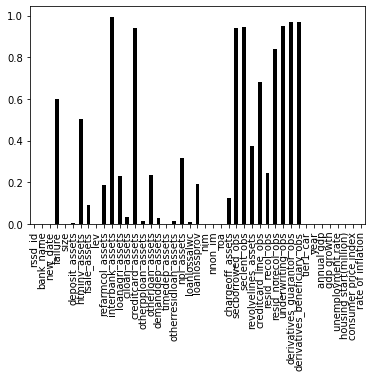

In [29]:
test = ((raw[raw == 0].count(axis=0)/len(raw.index)).reset_index(name='percetage of 0') \
                             .sort_values(['percetage of 0'], ascending=False)).plot.bar(color='k')
(raw[raw == 0].count(axis=0)/len(raw.index)).plot.bar(color='k')

In [2]:
# loading raw dataset
! wget https://github.com/PamPeiChi/1151Artificial_Intelligence_Project/raw/main/Data/financial_ratios_combined.zip
!unzip /content/financial_ratios_combined.zip
raw = pd.read_csv('/content/financial_ratios_combined.csv',encoding = 'unicode_escape')
print(f'There are {len(raw.columns)} columns in raw data')
raw_train, raw_test = Preprocess(raw)
raw = raw_train.append(raw_test)
'''
from google.colab import files
SmoteEnn(raw_train).to_csv('SmoteEnn_train.csv', encoding = 'utf-8-sig') 
SmoteTomek(raw_train).to_csv('SmoteTomek_train.csv', encoding = 'utf-8-sig') 
SmoteEnn(raw_test).to_csv('SmoteEnn_test.csv', encoding = 'utf-8-sig') 
SmoteTomek(raw_test).to_csv('SmoteTomek_test.csv', encoding = 'utf-8-sig') 
'''
# loading resampling dataset
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

data_Enn = pd.read_csv('/content/drive/My Drive/AI for social good/SmoteEnn_train.csv').iloc[: , 1:]
data_Enn_test = pd.read_csv('/content/drive/My Drive/AI for social good/SmoteEnn_test.csv').iloc[: , 1:]
data_Enn = data_Enn.append(data_Enn_test)

data_Tomek = pd.read_csv('/content/drive/My Drive/AI for social good/SmoteTomek_train.csv').iloc[: , 1:]
data_Tomek_test = pd.read_csv('/content/drive/My Drive/AI for social good/SmoteTomek_test.csv').iloc[: , 1:]
data_Tomek = data_Enn.append(data_Tomek_test)

--2022-06-13 13:44:41--  https://github.com/PamPeiChi/1151Artificial_Intelligence_Project/raw/main/Data/financial_ratios_combined.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PamPeiChi/1151Artificial_Intelligence_Project/main/Data/financial_ratios_combined.zip [following]
--2022-06-13 13:44:41--  https://raw.githubusercontent.com/PamPeiChi/1151Artificial_Intelligence_Project/main/Data/financial_ratios_combined.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21546729 (21M) [application/zip]
Saving to: ‘financial_ratios_combined.zip’

financial_ratios_co 100%[===================>]  20.5

EDA

Frequency of default times


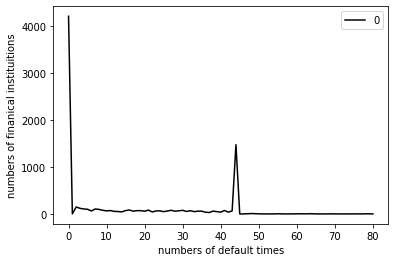

Default rate proportion


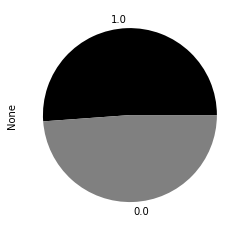

Numbers of finanical institution in years


Text(0, 0.5, 'numbers of finaicial institution')

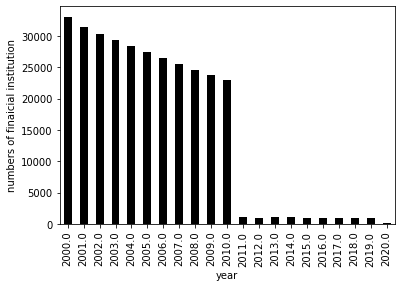

In [5]:
print('Frequency of default times')
pd.DataFrame(pd.DataFrame(raw.groupby(['rssd_id'])['failure'].sum())\
  .value_counts('failure').sort_index()).plot(color='k')
plt.xlabel('numbers of default times')
plt.ylabel('numbers of finanical instituitions')
plt.show()

print('Default rate proportion')
pd.DataFrame(raw.groupby(['rssd_id'])['failure'].sum()/raw\
      .groupby(['rssd_id'])['failure'].count()).value_counts('failure').plot.pie(colors=['black','grey'])
plt.show()

print('Numbers of finanical institution in years')
raw.groupby(['year'])['failure'].count().plot.bar(color='k')
plt.ylabel('numbers of finaicial institution')

## Experiments

#### Preliminary investigation:in and out-of sample test

In-sample Test

==================== Logistic Regression ====================


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:812: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:812: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.7/dist-packages/sklearn/linear_

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.66      0.83      0.74    178758
         1.0       0.62      0.39      0.48    124691

    accuracy                           0.65    303449
   macro avg       0.64      0.61      0.61    303449
weighted avg       0.64      0.65      0.63    303449



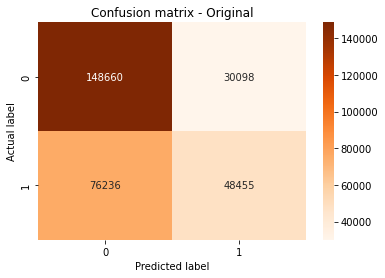

Kfold report:
               precision    recall  f1-score   support

         0.0       0.66      0.83      0.73    178758
         1.0       0.61      0.39      0.47    124691

    accuracy                           0.65    303449
   macro avg       0.64      0.61      0.60    303449
weighted avg       0.64      0.65      0.63    303449



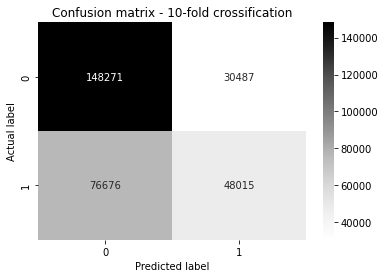

==================== Linear Regression ====================
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.64      0.89      0.75    178758
         1.0       0.65      0.29      0.40    124691

    accuracy                           0.64    303449
   macro avg       0.65      0.59      0.57    303449
weighted avg       0.65      0.64      0.60    303449



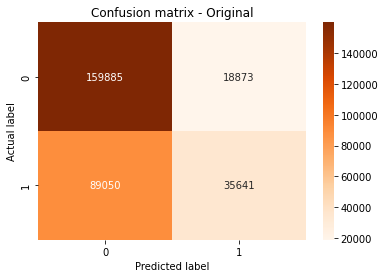

Kfold report:
               precision    recall  f1-score   support

         0.0       0.65      0.87      0.74    178758
         1.0       0.63      0.32      0.42    124691

    accuracy                           0.64    303449
   macro avg       0.64      0.59      0.58    303449
weighted avg       0.64      0.64      0.61    303449



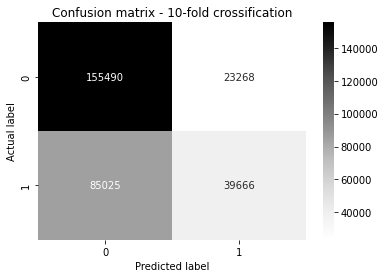

In [84]:
print("="*20,'Logistic Regression','='*20)
Logi_model = logisticRegression(X_train, y_train)
model_evaluation(Logi_model,X_train, y_train, X_train, y_train)
print("="*20,'Linear Regression','='*20)
lin_model = linearRegression(X_train, y_train)
model_evaluation(lin_model, X_train, y_train, X_train, y_train)

==================== KNN ====================
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.77      0.86      0.81    178758
         1.0       0.75      0.62      0.68    124691

    accuracy                           0.76    303449
   macro avg       0.76      0.74      0.75    303449
weighted avg       0.76      0.76      0.76    303449



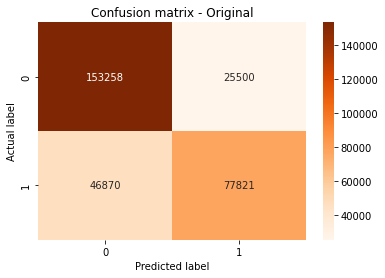

Kfold report:
               precision    recall  f1-score   support

         0.0       0.64      0.73      0.68    178758
         1.0       0.52      0.43      0.47    124691

    accuracy                           0.60    303449
   macro avg       0.58      0.58      0.58    303449
weighted avg       0.59      0.60      0.60    303449



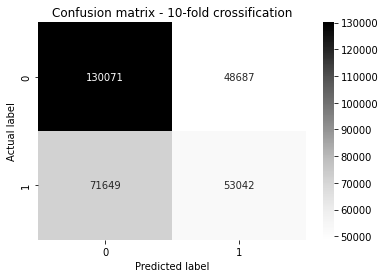

In [83]:
print("="*20,'KNN','='*20)
knn_model = knn_method(X_train, y_train)
model_evaluation(knn_model, X_train, y_train, X_train, y_train)

Raw - XGBRF
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.64      0.87      0.74    178758
         1.0       0.61      0.28      0.39    124691

    accuracy                           0.63    303449
   macro avg       0.62      0.58      0.56    303449
weighted avg       0.62      0.63      0.59    303449



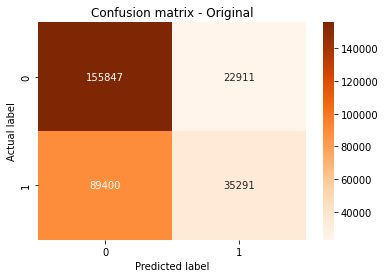

Kfold report:
               precision    recall  f1-score   support

         0.0       0.63      0.72      0.67    178758
         1.0       0.49      0.38      0.43    124691

    accuracy                           0.58    303449
   macro avg       0.56      0.55      0.55    303449
weighted avg       0.57      0.58      0.57    303449



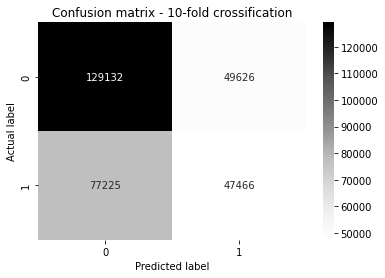

Raw - Xgboost


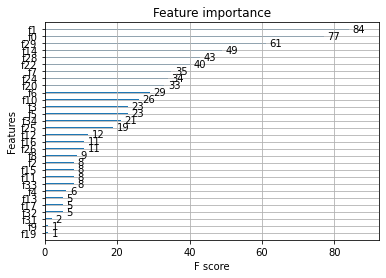

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.68      0.86      0.76    178758
         1.0       0.69      0.43      0.53    124691

    accuracy                           0.68    303449
   macro avg       0.69      0.65      0.65    303449
weighted avg       0.69      0.68      0.67    303449



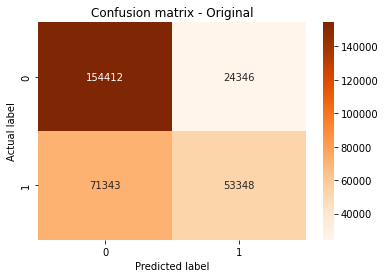

Kfold report:
               precision    recall  f1-score   support

         0.0       0.64      0.64      0.64    178758
         1.0       0.48      0.48      0.48    124691

    accuracy                           0.57    303449
   macro avg       0.56      0.56      0.56    303449
weighted avg       0.57      0.57      0.57    303449



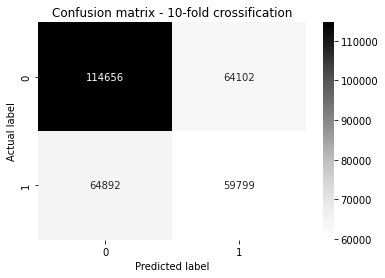

In [80]:
print("="*20,'Raw', "="*20)
data = Scale(raw)
X_train = data[0][:-len(raw_test)]
y_train = data[1][:-len(raw_test)]
X_test = data[0][-len(raw_test):]
y_test = data[1][-len(raw_test):]
print('Raw - Random Forest')
RF_model = forest(X_train, y_train)
model_evaluation(RF_model, X_train, y_train, X_train, y_train)
print('Raw - XGBRF')
XGBRF_model = XGBRF(X_train, y_train)
model_evaluation(XGBRF_model, X_train, y_train, X_train, y_train)
print("Raw - Xgboost")
Xgboost_model = Xgboost(X_train, y_train)
model_evaluation(Xgboost_model, X_train, y_train, X_train, y_train)
##########################################
print("="*20,'Logistic Regression','='*20)
Logi_model = logisticRegression(X_train, y_train)
model_evaluation(Logi_model,X_train, y_train, X_train, y_train)
print("="*20,'Linear Regression','='*20)
lin_model = linearRegression(X_train, y_train)
model_evaluation(lin_model, X_train, y_train, X_train, y_train)

Out-of-sample test

out-of-sample - XGBRF
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.87      0.72      0.79      7893
         1.0       0.17      0.35      0.22      1266

    accuracy                           0.67      9159
   macro avg       0.52      0.53      0.51      9159
weighted avg       0.78      0.67      0.71      9159



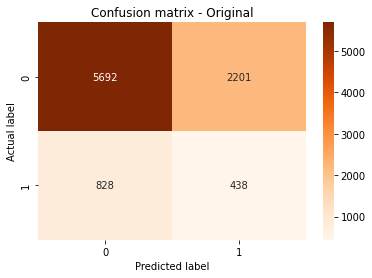

Kfold report:
               precision    recall  f1-score   support

         0.0       0.87      0.98      0.92      7893
         1.0       0.42      0.09      0.15      1266

    accuracy                           0.86      9159
   macro avg       0.65      0.53      0.53      9159
weighted avg       0.81      0.86      0.81      9159



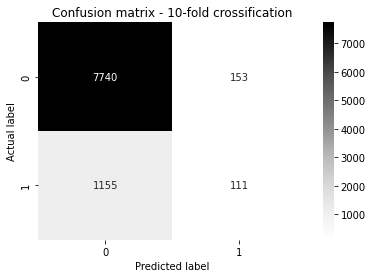

out-of-sample - Random Forest
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.95      0.73      0.83      7893
         1.0       0.31      0.74      0.43      1266

    accuracy                           0.73      9159
   macro avg       0.63      0.74      0.63      9159
weighted avg       0.86      0.73      0.77      9159



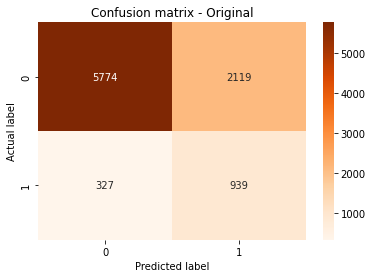

Kfold report:
               precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      7893
         1.0       0.51      0.22      0.31      1266

    accuracy                           0.86      9159
   macro avg       0.70      0.59      0.62      9159
weighted avg       0.83      0.86      0.84      9159



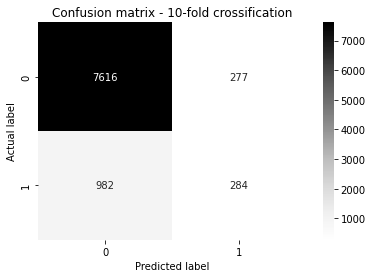

'out-of-sample - Xgboost


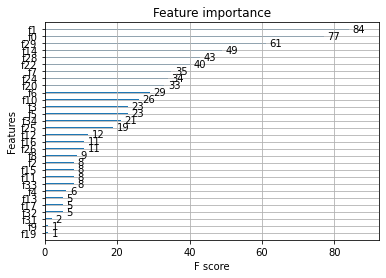

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.89      0.54      0.67      7893
         1.0       0.16      0.57      0.25      1266

    accuracy                           0.54      9159
   macro avg       0.52      0.55      0.46      9159
weighted avg       0.79      0.54      0.61      9159



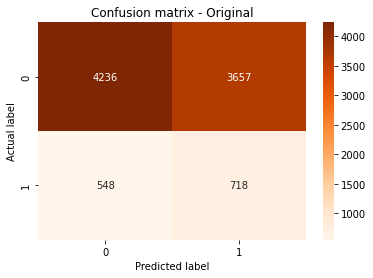

Kfold report:
               precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      7893
         1.0       0.25      0.21      0.23      1266

    accuracy                           0.80      9159
   macro avg       0.56      0.55      0.56      9159
weighted avg       0.79      0.80      0.80      9159



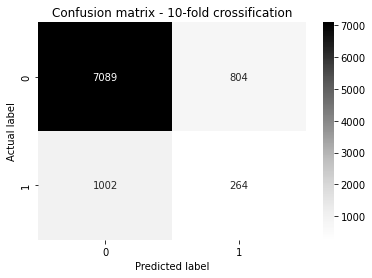

'out-of-sample - KNN
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      7893
         1.0       0.29      0.41      0.34      1266

    accuracy                           0.78      9159
   macro avg       0.60      0.63      0.61      9159
weighted avg       0.82      0.78      0.80      9159



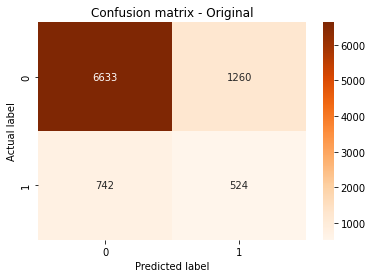

Kfold report:
               precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      7893
         1.0       0.27      0.14      0.18      1266

    accuracy                           0.83      9159
   macro avg       0.57      0.54      0.54      9159
weighted avg       0.79      0.83      0.80      9159



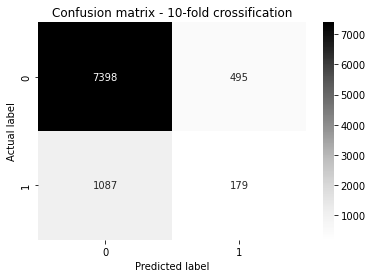

==================== Logistic Regression ====================


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:812: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:812: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.7/dist-packages/sklearn/linear_

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.87      0.99      0.92      7893
         1.0       0.44      0.04      0.08      1266

    accuracy                           0.86      9159
   macro avg       0.65      0.52      0.50      9159
weighted avg       0.81      0.86      0.81      9159



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:812: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


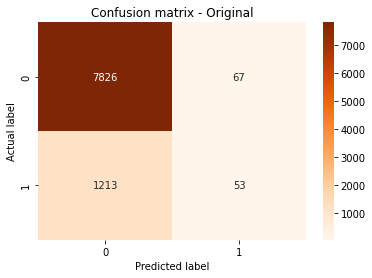

Kfold report:
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      7893
         1.0       0.57      0.13      0.21      1266

    accuracy                           0.87      9159
   macro avg       0.72      0.56      0.57      9159
weighted avg       0.83      0.87      0.83      9159



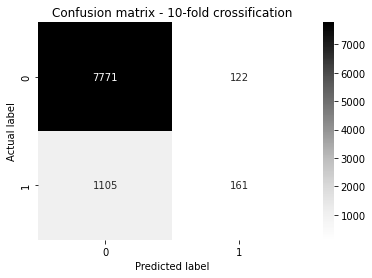

==================== Linear Regression ====================
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.87      0.99      0.93      7893
         1.0       0.53      0.05      0.09      1266

    accuracy                           0.86      9159
   macro avg       0.70      0.52      0.51      9159
weighted avg       0.82      0.86      0.81      9159



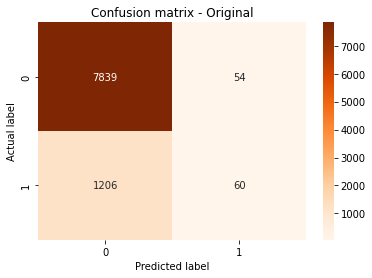

Kfold report:
               precision    recall  f1-score   support

         0.0       0.87      0.99      0.93      7893
         1.0       0.55      0.05      0.10      1266

    accuracy                           0.86      9159
   macro avg       0.71      0.52      0.51      9159
weighted avg       0.82      0.86      0.81      9159



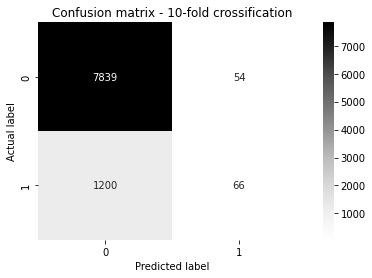

In [86]:
# Out-of-sample test
print('out-of-sample - XGBRF')
XGBRF_model = XGBRF(X_train, y_train)
model_evaluation(XGBRF_model, X_train, y_train, X_test, y_test) 
print('out-of-sample - Random Forest')
RF_model = forest(X_train, y_train)
model_evaluation(RF_model, X_train, y_train, X_test, y_test)
print("'out-of-sample - Xgboost")
Xgboost_model = Xgboost(X_train, y_train)
model_evaluation(Xgboost_model, X_train, y_train, X_test, y_test)
print("'out-of-sample - KNN")
knn_model = knn_method(X_train, y_train)
model_evaluation(knn_model, X_train, y_train, X_test, y_test)
print("="*20,'Logistic Regression','='*20)
Logi_model = logisticRegression(X_train, y_train)
model_evaluation(Logi_model,X_train, y_train, X_test, y_test)
print("="*20,'Linear Regression','='*20)
lin_model = linearRegression(X_train, y_train)
model_evaluation(lin_model, X_train, y_train, X_test, y_test)

housing start(million)    0.087653
month                    -0.023868
refarmcol_assets         -0.103732
gdp growth                0.058160
roa                      -0.075418
fsale_assets             -0.062519
loanagri_assets          -0.060546
otherresidloan_assets    -0.053648
tier1_car                -0.031881
size                     -0.035716
underwriting_obs         -0.009368
deposit_assets           -0.030396
otherpploan_assets       -0.029278
nnon_im                  -0.028159
timedep_assets           -0.024416
date                     -0.011391
revolvelines_assets       0.074081
htminv_assets            -0.018263
npl_assets               -0.011852
rate of inflation         0.043612
resid_norecol_obs         0.007319
demanddep_assets         -0.008227
nim                       0.002424
year                     -0.123016
lev                       0.003633
resid_recol_obs           0.108057
otherloan_assets          0.017447
rssd_id                   0.021406
ciloan_assets       

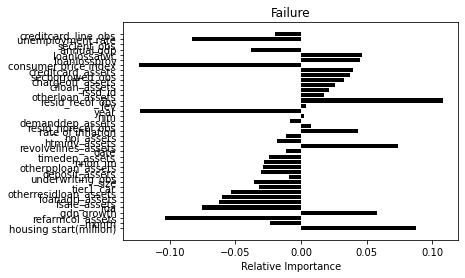

Removing those features whose correlation are lower than 0.025, now we got
size
deposit_assets
fsale_assets
refarmcol_assets
loanagri_assets
ciloan_assets
creditcard_assets
otherpploan_assets
otherresidloan_assets
loanlossalwc
loanlossprov
nnon_im
roa
chargeoff_assets
secborrowed_obs
revolvelines_assets
resid_recol_obs
tier1_car
annual gdp
gdp growth
unemployment rate
housing start(million)
consumer price index
rate of inflation
year
size  is not correlated  with  creditcard_assets
size  is not correlated  with  roa
deposit_assets  is not correlated  with  fsale_assets
deposit_assets  is not correlated  with  refarmcol_assets
deposit_assets  is not correlated  with  loanagri_assets
deposit_assets  is not correlated  with  ciloan_assets
deposit_assets  is not correlated  with  creditcard_assets
deposit_assets  is not correlated  with  resid_recol_obs
deposit_assets  is not correlated  with  annual gdp
deposit_assets  is not correlated  with  gdp growth
deposit_assets  is not correlated 

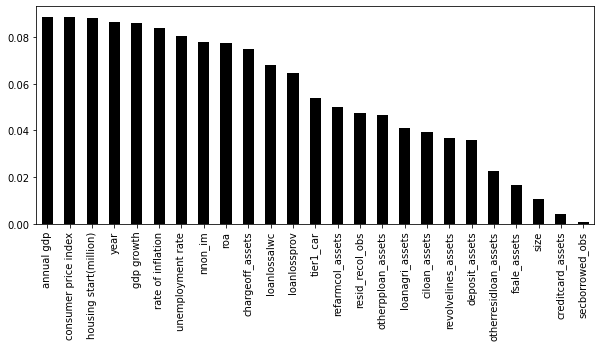

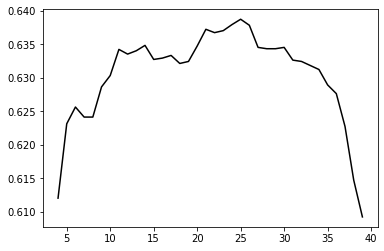

feature_idx         cv_scores  \
25  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 22, 25,...  [0.6278, 0.6496]   

   avg_score                                      feature_names  ci_bound  \
25    0.6387  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 22, 25,...  0.046899   

   std_dev std_err  
25  0.0109  0.0109

We select 25 features, which are:
rssd_id
size
htminv_assets
lev
loanagri_assets
ciloan_assets
demanddep_assets
loanlossalwc
loanlossprov
nnon_im
roa
secborrowed_obs
creditcard_line_obs
resid_recol_obs
resid_norecol_obs
underwriting_obs
tier1_car
annual gdp
unemployment rate
housing start(million)
consumer price index
rate of inflation
date
month
year


feature_idx         cv_scores  \
39  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   [0.6094, 0.609]   
38  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...   [0.6064, 0.623]   
37  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15...  [0.6198, 0.6256]   
36  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15...   [0.6212, 0.634]   
35  (0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 15, 1...  [0.6266, 0.6312]   
34  (0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 15, 1...  [0.6286, 0.6338]   
33  (0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 15, 1...   [0.6306, 0.633]   
32  (0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 13, 15, 16, ...   [0.6298, 0.635]   
31  (0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 17, ...  [0.6306, 0.6346]   
30  (0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 16, 17, 19, ...  [0.6324, 0.6366]   
29  (0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 16, 17, 19, ...  [0.6302, 0.6384]   
28  (0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 16, 17, 19, ...   [0.6306, 0.638]   
27  (0, 1, 3, 5, 7, 8, 9, 10, 12, 16, 17, 19, 20, ...  [0.6282, 0.6408]   
26  (0, 1, 3, 5, 7, 8, 9, 12, 16, 17, 19, 20, 22, ...   [0.626, 0.6496]   
25  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 22, 25,...  [0.6278, 0.6496]   
24  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 22, 25,...   [0.627, 0.6488]   
23  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 22, 25,...  [0.6262, 0.6478]   
22  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 22, 25,...  [0.6252, 0.6482]   
21  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 25, 26,...  [0.6256, 0.6488]   
20  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 25, 26,...   [0.6254, 0.644]   
19  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 25, 26,...  [0.6196, 0.6452]   
18  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 25, 26,...   [0.6252, 0.639]   
17  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 25, 26,...   [0.626, 0.6406]   
16  (0, 1, 3, 5, 7, 8, 12, 16, 19, 20, 25, 26, 29,...   [0.6228, 0.643]   
15  (0, 1, 3, 5, 7, 8, 12, 16, 20, 25, 26, 29, 33,...   [0.624, 0.6414]   
14  (0, 1, 3, 5, 7, 8, 12, 20, 25, 26, 29, 33, 37,...  [0.6268, 0.6428]   
13     (0, 1, 3, 5, 7, 8, 12, 20, 25, 29, 33, 37, 38)  [0.6278, 0.6402]   
12        (0, 1, 3, 5, 7, 12, 20, 25, 29, 33, 37, 38)    [0.626, 0.641]   
11           (0, 1, 3, 7, 12, 20, 25, 29, 33, 37, 38)   [0.6214, 0.647]   
10               (0, 1, 3, 7, 20, 25, 29, 33, 37, 38)  [0.6214, 0.6392]   
9                    (0, 1, 3, 7, 20, 25, 29, 37, 38)    [0.62, 0.6372]   
8                       (0, 1, 7, 20, 25, 29, 37, 38)   [0.6162, 0.632]   
7                           (0, 1, 7, 25, 29, 37, 38)   [0.6112, 0.637]   
6                               (0, 1, 7, 29, 37, 38)  [0.6156, 0.6356]   
5                                  (1, 7, 29, 37, 38)  [0.6078, 0.6384]   
4                                      (1, 7, 29, 37)    [0.608, 0.616]   

   avg_score                                      feature_names  ci_bound  \
39    0.6092  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.000861   
38    0.6147  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...  0.035712   
37    0.6227  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15...  0.012478   
36    0.6276  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15...  0.027537   
35    0.6289  (0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 15, 1...  0.009896   
34    0.6312  (0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 15, 1...  0.011187   
33    0.6318  (0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 15, 1...  0.005163   
32    0.6324  (0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 13, 15, 16, ...  0.011187   
31    0.6326  (0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 17, ...  0.008605   
30    0.6345  (0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 16, 17, 19, ...  0.009036   
29    0.6343  (0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 16, 17, 19, ...  0.017641   
28    0.6343  (0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 16, 17, 19, ...   0.01592   
27    0.6345  (0, 1, 3, 5, 7, 8, 9, 10, 12, 16, 17, 19, 20, ...  0.027107   
26    0.6378  (0, 1, 3, 5, 7, 8, 9, 12, 16, 17, 19, 20, 22, ...  0.050771   
25    0.6387  (0, 1, 3, 5, 7, 8, 12, 16, 17, 19, 20, 22, 25,...  0.046899   
24    0.6379  (0, 1, 3, 5, 7, 8, 1

consumer price index     -0.123824
year                     -0.123016
unemployment rate        -0.083180
roa                      -0.075418
loanagri_assets          -0.060546
annual gdp               -0.038495
size                     -0.035716
tier1_car                -0.031881
nnon_im                  -0.028159
month                    -0.023868
creditcard_line_obs      -0.020077
htminv_assets            -0.018263
date                     -0.011391
underwriting_obs         -0.009368
demanddep_assets         -0.008227
lev                       0.003633
resid_norecol_obs         0.007319
rssd_id                   0.021406
ciloan_assets             0.026016
secborrowed_obs           0.037407
rate of inflation         0.043612
loanlossprov              0.044622
loanlossalwc              0.046325
housing start(million)    0.087653
resid_recol_obs           0.108057
dtype: float64


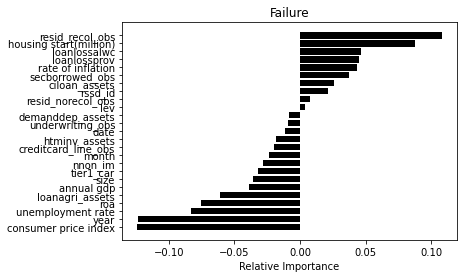

Removing those features whose correlation are lower than 0.025, now we got
size
loanagri_assets
ciloan_assets
loanlossalwc
loanlossprov
nnon_im
roa
secborrowed_obs
resid_recol_obs
tier1_car
annual gdp
unemployment rate
housing start(million)
consumer price index
rate of inflation
year
size  is not correlated  with  roa
loanagri_assets  is not correlated  with  secborrowed_obs
loanagri_assets  is not correlated  with  annual gdp
loanagri_assets  is not correlated  with  unemployment rate
loanagri_assets  is not correlated  with  housing start(million)
loanagri_assets  is not correlated  with  rate of inflation
ciloan_assets  is not correlated  with  nnon_im
ciloan_assets  is not correlated  with  roa
ciloan_assets  is not correlated  with  secborrowed_obs
ciloan_assets  is not correlated  with  housing start(million)
ciloan_assets  is not correlated  with  rate of inflation
loanlossalwc  is not correlated  with  secborrowed_obs
loanlossprov  is not correlated  with  secborrowed_obs
loan

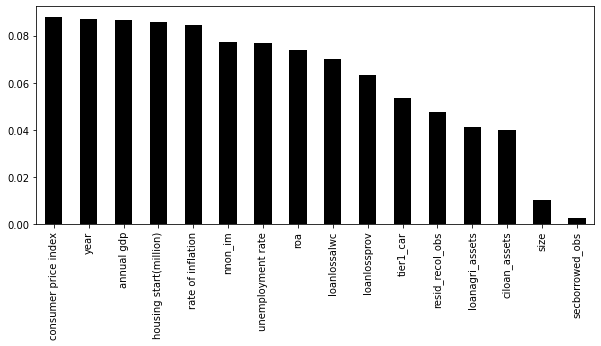

housing start(million)    0.078598
month                    -0.025394
refarmcol_assets         -0.097313
roa                      -0.071415
gdp growth                0.057604
fsale_assets             -0.064132
size                     -0.054044
loanagri_assets          -0.053558
otherresidloan_assets    -0.046873
tier1_car                -0.018551
deposit_assets           -0.030299
nnon_im                  -0.029275
revolvelines_assets       0.067896
date                     -0.010746
otherpploan_assets       -0.024416
timedep_assets           -0.024096
underwriting_obs         -0.010058
htminv_assets            -0.018157
rate of inflation         0.042833
npl_assets               -0.010500
resid_norecol_obs        -0.001505
demanddep_assets         -0.010054
lev                      -0.009115
year                     -0.114268
resid_recol_obs           0.102074
nim                       0.006091
otherloan_assets          0.012367
rssd_id                   0.013688
ciloan_assets       

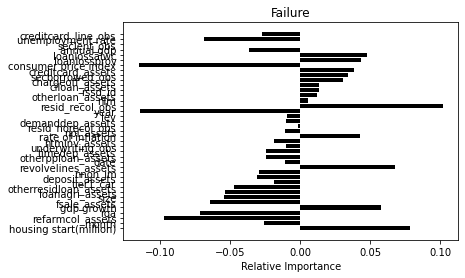

Removing those features whose correlation are lower than 0.025, now we got
size
deposit_assets
fsale_assets
refarmcol_assets
loanagri_assets
creditcard_assets
otherresidloan_assets
loanlossalwc
loanlossprov
nnon_im
roa
chargeoff_assets
secborrowed_obs
revolvelines_assets
creditcard_line_obs
resid_recol_obs
annual gdp
gdp growth
unemployment rate
housing start(million)
consumer price index
rate of inflation
month
year
size  is not correlated  with  creditcard_assets
size  is not correlated  with  roa
size  is not correlated  with  month
deposit_assets  is not correlated  with  fsale_assets
deposit_assets  is not correlated  with  refarmcol_assets
deposit_assets  is not correlated  with  creditcard_assets
deposit_assets  is not correlated  with  resid_recol_obs
deposit_assets  is not correlated  with  annual gdp
deposit_assets  is not correlated  with  gdp growth
deposit_assets  is not correlated  with  unemployment rate
deposit_assets  is not correlated  with  rate of inflation
deposit_

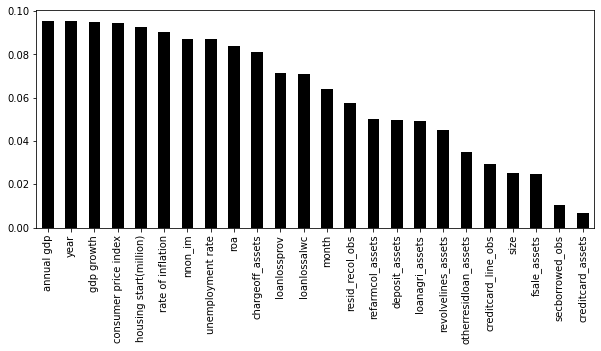

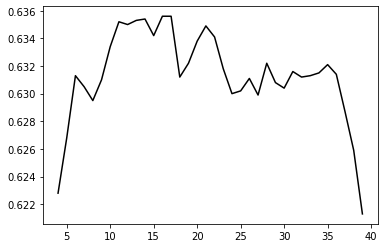

feature_idx         cv_scores  \
17  (0, 1, 7, 10, 11, 12, 18, 25, 26, 28, 29, 30, ...  [0.6496, 0.6216]   
16  (0, 1, 7, 10, 11, 12, 18, 25, 26, 28, 29, 30, ...  [0.6514, 0.6198]   

   avg_score                                      feature_names  ci_bound  \
17    0.6356  (0, 1, 7, 10, 11, 12, 18, 25, 26, 28, 29, 30, ...  0.060237   
16    0.6356  (0, 1, 7, 10, 11, 12, 18, 25, 26, 28, 29, 30, ...  0.067982   

   std_dev std_err  
17   0.014   0.014  
16  0.0158  0.0158

We select 17 features, which are:
rssd_id
size
loanagri_assets
otherpploan_assets
otherloan_assets
demanddep_assets
nim
creditcard_line_obs
resid_recol_obs
underwriting_obs
tier1_car
annual gdp
unemployment rate
rate of inflation
date
month
year


feature_idx         cv_scores  \
39  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  [0.6278, 0.6148]   
38  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  [0.6304, 0.6214]   
37  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...   [0.6324, 0.625]   
36  (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...  [0.6334, 0.6294]   
35  (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...  [0.6334, 0.6308]   
34  (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...  [0.6334, 0.6296]   
33  (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...    [0.6326, 0.63]   
32  (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 1...  [0.6326, 0.6298]   
31  (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 1...  [0.6348, 0.6284]   
30  (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 1...   [0.632, 0.6288]   
29  (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 1...   [0.634, 0.6276]   
28  (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 16, 1...    [0.6344, 0.63]   
27  (0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 14, 16, 17, ...  [0.6316, 0.6282]   
26  (0, 1, 5, 6, 7, 8, 10, 11, 12, 14, 16, 17, 18,...  [0.6324, 0.6298]   
25  (0, 1, 5, 6, 7, 8, 10, 11, 12, 14, 17, 18, 20,...  [0.6368, 0.6236]   
24  (0, 1, 5, 6, 7, 8, 10, 11, 12, 14, 17, 18, 20,...  [0.6338, 0.6262]   
23  (0, 1, 5, 6, 7, 8, 10, 11, 12, 17, 18, 20, 25,...  [0.6362, 0.6274]   
22  (0, 1, 5, 6, 7, 8, 10, 11, 12, 18, 20, 25, 26,...    [0.6382, 0.63]   
21  (0, 1, 6, 7, 8, 10, 11, 12, 18, 20, 25, 26, 28...   [0.6378, 0.632]   
20  (0, 1, 7, 8, 10, 11, 12, 18, 20, 25, 26, 28, 2...  [0.6384, 0.6292]   
19  (0, 1, 7, 10, 11, 12, 18, 20, 25, 26, 28, 29, ...  [0.6446, 0.6198]   
18  (0, 1, 7, 10, 11, 12, 18, 25, 26, 28, 29, 30, ...  [0.6458, 0.6166]   
17  (0, 1, 7, 10, 11, 12, 18, 25, 26, 28, 29, 30, ...  [0.6496, 0.6216]   
16  (0, 1, 7, 10, 11, 12, 18, 25, 26, 28, 29, 30, ...  [0.6514, 0.6198]   
15  (0, 1, 7, 10, 11, 12, 18, 25, 28, 29, 30, 32, ...  [0.6416, 0.6268]   
14  (0, 1, 7, 10, 11, 18, 25, 28, 29, 30, 32, 36, ...  [0.6446, 0.6262]   
13  (0, 1, 7, 10, 11, 18, 25, 28, 29, 30, 32, 36, 37)  [0.6362, 0.6344]   
12     (1, 7, 10, 11, 18, 25, 28, 29, 30, 32, 36, 37)  [0.6336, 0.6364]   
11         (1, 7, 10, 18, 25, 28, 29, 30, 32, 36, 37)  [0.6376, 0.6328]   
10             (1, 7, 10, 18, 25, 28, 29, 32, 36, 37)  [0.6352, 0.6316]   
9                  (1, 7, 10, 18, 25, 29, 32, 36, 37)    [0.638, 0.624]   
8                      (1, 7, 18, 25, 29, 32, 36, 37)  [0.6412, 0.6178]   
7                          (1, 7, 18, 29, 32, 36, 37)  [0.6394, 0.6216]   
6                              (1, 7, 18, 29, 36, 37)   [0.635, 0.6276]   
5                                  (1, 7, 29, 36, 37)    [0.6336, 0.62]   
4                                     (1, 29, 36, 37)  [0.6172, 0.6284]   

   avg_score                                      feature_names  ci_bound  \
39    0.6213  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.027967   
38    0.6259  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.019362   
37    0.6287  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...   0.01592   
36    0.6314  (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...  0.008605   
35    0.6321  (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...  0.005593   
34    0.6315  (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...  0.008175   
33    0.6313  (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...  0.005593   
32    0.6312  (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 1...  0.006024   
31    0.6316  (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 1...  0.013768   
30    0.6304  (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 1...  0.006884   
29    0.6308  (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 1...  0.013768   
28    0.6322  (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 16, 1...  0.009466   
27    0.6299  (0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 14, 16, 17, ...  0.007315   
26    0.6311  (0, 1, 5, 6, 7, 8, 10, 11, 12, 14, 16, 17, 18,...  0.005593   
25    0.6302  (0, 1, 5, 6, 7, 8, 10, 11, 12, 14, 17, 18, 20,...  0.028398   
24      0.63  (0, 1, 5, 6, 7, 8, 1

year                  -0.114268
unemployment rate     -0.068197
size                  -0.054044
loanagri_assets       -0.053558
annual gdp            -0.035965
creditcard_line_obs   -0.027276
month                 -0.025394
otherpploan_assets    -0.024416
tier1_car             -0.018551
date                  -0.010746
underwriting_obs      -0.010058
demanddep_assets      -0.010054
nim                    0.006091
otherloan_assets       0.012367
rssd_id                0.013688
rate of inflation      0.042833
resid_recol_obs        0.102074
dtype: float64


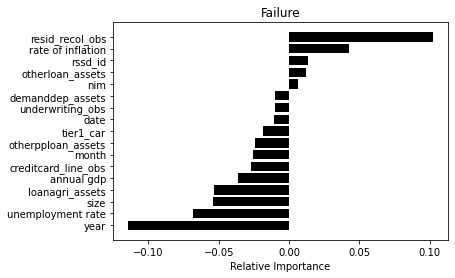

Removing those features whose correlation are lower than 0.025, now we got
size
loanagri_assets
creditcard_line_obs
resid_recol_obs
annual gdp
unemployment rate
rate of inflation
month
year
size  is not correlated  with  month
loanagri_assets  is not correlated  with  annual gdp
loanagri_assets  is not correlated  with  rate of inflation
loanagri_assets  is not correlated  with  month
creditcard_line_obs  is not correlated  with  annual gdp
creditcard_line_obs  is not correlated  with  month
resid_recol_obs  is not correlated  with  month
annual gdp  is not correlated  with  loanagri_assets
annual gdp  is not correlated  with  creditcard_line_obs
annual gdp  is not correlated  with  month
unemployment rate  is not correlated  with  month
rate of inflation  is not correlated  with  loanagri_assets
rate of inflation  is not correlated  with  month
month  is not correlated  with  size
month  is not correlated  with  loanagri_assets
month  is not correlated  with  creditcard_line_obs
month

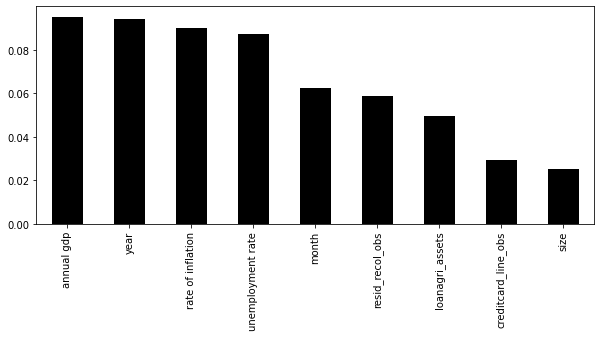

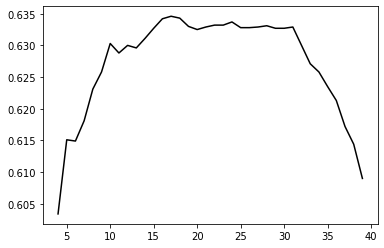

feature_idx        cv_scores  \
17  (0, 1, 3, 5, 6, 7, 10, 11, 13, 14, 16, 18, 19,...  [0.6372, 0.632]   

   avg_score                                      feature_names  ci_bound  \
17    0.6346  (0, 1, 3, 5, 6, 7, 10, 11, 13, 14, 16, 18, 19,...  0.011187   

   std_dev std_err  
17  0.0026  0.0026

We select 17 features, which are:
rssd_id
failure
deposit_assets
fsale_assets
lev
refarmcol_assets
creditcard_assets
otherpploan_assets
demanddep_assets
timedep_assets
npl_assets
loanlossprov
nim
chargeoff_assets
seclent_obs
revolvelines_assets
month


feature_idx         cv_scores  \
39  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  [0.6162, 0.6018]   
38  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...    [0.61, 0.6188]   
37  (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  [0.6126, 0.6218]   
36  (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   [0.617, 0.6256]   
35  (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  [0.6182, 0.6288]   
34  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1...  [0.6228, 0.6288]   
33  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 1...   [0.626, 0.6282]   
32  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  [0.6338, 0.6262]   
31  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...    [0.6358, 0.63]   
30  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  [0.6356, 0.6298]   
29  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...   [0.6344, 0.631]   
28  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...   [0.635, 0.6312]   
27  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...   [0.635, 0.6308]   
26  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...   [0.6346, 0.631]   
25  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...   [0.634, 0.6316]   
24  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  [0.6356, 0.6318]   
23  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...   [0.6344, 0.632]   
22  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  [0.6346, 0.6318]   
21  (0, 1, 2, 3, 5, 6, 7, 10, 11, 13, 14, 16, 18, ...  [0.6344, 0.6314]   
20  (0, 1, 2, 3, 5, 6, 7, 10, 11, 13, 14, 16, 18, ...    [0.634, 0.631]   
19  (0, 1, 2, 3, 5, 6, 7, 10, 11, 13, 14, 16, 18, ...    [0.644, 0.622]   
18  (0, 1, 2, 3, 5, 6, 7, 10, 11, 13, 14, 16, 18, ...  [0.6434, 0.6252]   
17  (0, 1, 3, 5, 6, 7, 10, 11, 13, 14, 16, 18, 19,...   [0.6372, 0.632]   
16  (0, 1, 3, 5, 6, 7, 10, 11, 13, 14, 16, 18, 22,...    [0.6384, 0.63]   
15  (0, 1, 3, 5, 6, 7, 10, 11, 13, 14, 16, 18, 24,...  [0.6382, 0.6272]   
14  (0, 1, 3, 5, 6, 7, 10, 11, 13, 14, 16, 24, 25,...  [0.6388, 0.6234]   
13     (0, 1, 3, 5, 6, 7, 10, 13, 14, 16, 24, 25, 38)   [0.6322, 0.627]   
12         (0, 1, 3, 5, 6, 7, 13, 14, 16, 24, 25, 38)  [0.6366, 0.6234]   
11             (0, 1, 3, 5, 6, 7, 14, 16, 24, 25, 38)  [0.6324, 0.6252]   
10                (0, 1, 5, 6, 7, 14, 16, 24, 25, 38)  [0.6334, 0.6272]   
9                     (0, 1, 5, 6, 7, 14, 16, 25, 38)   [0.632, 0.6196]   
8                        (1, 5, 6, 7, 14, 16, 25, 38)   [0.626, 0.6202]   
7                           (1, 5, 7, 14, 16, 25, 38)  [0.6188, 0.6174]   
6                               (1, 5, 7, 14, 16, 38)   [0.616, 0.6138]   
5                                   (1, 5, 7, 14, 38)   [0.6222, 0.608]   
4                                      (1, 5, 14, 38)  [0.6054, 0.6014]   

   avg_score                                      feature_names  ci_bound  \
39     0.609  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.030979   
38    0.6144  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.018932   
37    0.6172  (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.019792   
36    0.6213  (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.018501   
35    0.6235  (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.022804   
34    0.6258  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1...  0.012908   
33    0.6271  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 1...  0.004733   
32      0.63  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...   0.01635   
31    0.6329  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  0.012478   
30    0.6327  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  0.012478   
29    0.6327  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  0.007315   
28    0.6331  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  0.008175   
27    0.6329  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  0.009036   
26    0.6328  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  0.007745   
25    0.6328  (0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1...  0.005163   
24    0.6337  (0, 1, 2, 3, 5, 6, 7

refarmcol_assets      -0.094492
fsale_assets          -0.048477
timedep_assets        -0.025391
deposit_assets        -0.021267
otherpploan_assets    -0.017117
lev                   -0.007656
npl_assets            -0.006347
revolvelines_assets    0.070637
demanddep_assets       0.006403
nim                    0.010066
rssd_id                0.019706
chargeoff_assets       0.032151
loanlossprov           0.043975
month                 -0.001250
creditcard_assets      0.048920
seclent_obs                 NaN
dtype: float64


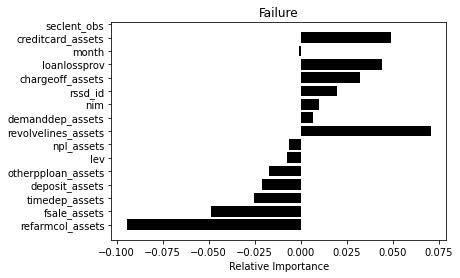

Removing those features whose correlation are lower than 0.025, now we got
fsale_assets
refarmcol_assets
creditcard_assets
timedep_assets
loanlossprov
chargeoff_assets
revolvelines_assets
fsale_assets  is not correlated  with  refarmcol_assets
fsale_assets  is not correlated  with  creditcard_assets
refarmcol_assets  is not correlated  with  fsale_assets
creditcard_assets  is not correlated  with  fsale_assets
creditcard_assets  is not correlated  with  timedep_assets
creditcard_assets  is not correlated  with  loanlossprov
creditcard_assets  is not correlated  with  chargeoff_assets
creditcard_assets  is not correlated  with  revolvelines_assets
timedep_assets  is not correlated  with  creditcard_assets
timedep_assets  is not correlated  with  loanlossprov
timedep_assets  is not correlated  with  chargeoff_assets
timedep_assets  is not correlated  with  revolvelines_assets
loanlossprov  is not correlated  with  creditcard_assets
loanlossprov  is not correlated  with  timedep_assets
ch

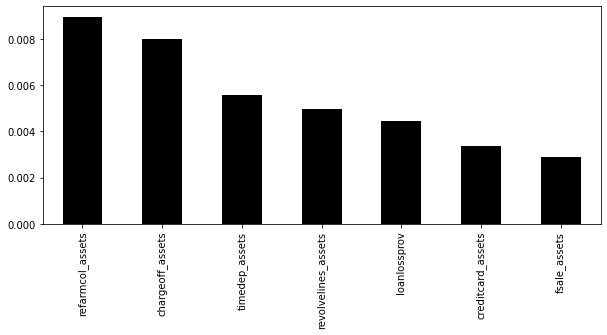

In [6]:
# variables
data_filter_Enn = filter(data_Enn)
data_wrapper_Enn = wrapper(data_Enn)
data_filter_wrapper_Enn = filter(data_wrapper_Enn)

data_filter_Tomek = filter(data_Tomek)
data_wrapper_Tomek = wrapper(data_Tomek)
data_filter_wrapper_Tomek = filter(data_wrapper_Tomek)

data_wraper_raw = wrapper(raw)
data_filter_wraper_raw = filter(data_wraper_raw)

==================== Raw ====================
number of features: 7
Raw - XGBRF
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.86      0.99      0.92      7893
         1.0       0.10      0.01      0.01      1266

    accuracy                           0.85      9159
   macro avg       0.48      0.50      0.47      9159
weighted avg       0.76      0.85      0.80      9159



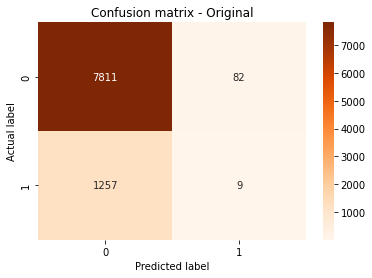

Kfold report:
               precision    recall  f1-score   support

         0.0       0.86      0.99      0.92      7893
         1.0       0.14      0.01      0.02      1266

    accuracy                           0.85      9159
   macro avg       0.50      0.50      0.47      9159
weighted avg       0.76      0.85      0.80      9159



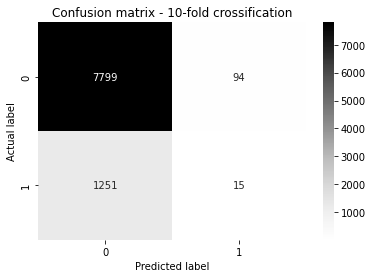

Raw - Random Forest
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.89      0.71      0.79      7893
         1.0       0.20      0.45      0.28      1266

    accuracy                           0.68      9159
   macro avg       0.54      0.58      0.53      9159
weighted avg       0.79      0.68      0.72      9159



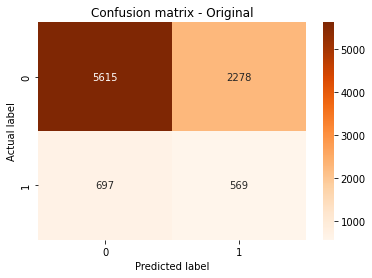

Kfold report:
               precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      7893
         1.0       0.33      0.15      0.21      1266

    accuracy                           0.84      9159
   macro avg       0.60      0.55      0.56      9159
weighted avg       0.80      0.84      0.81      9159



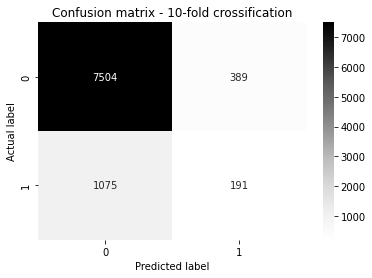

Raw - Xgboost


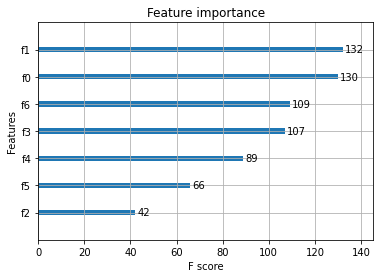

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.89      7893
         1.0       0.28      0.26      0.27      1266

    accuracy                           0.80      9159
   macro avg       0.58      0.58      0.58      9159
weighted avg       0.80      0.80      0.80      9159



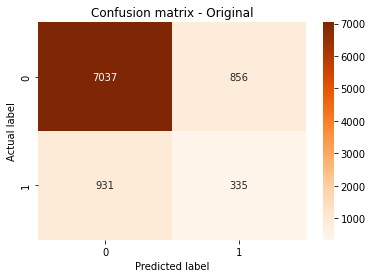

Kfold report:
               precision    recall  f1-score   support

         0.0       0.86      0.98      0.92      7893
         1.0       0.18      0.03      0.05      1266

    accuracy                           0.85      9159
   macro avg       0.52      0.50      0.49      9159
weighted avg       0.77      0.85      0.80      9159



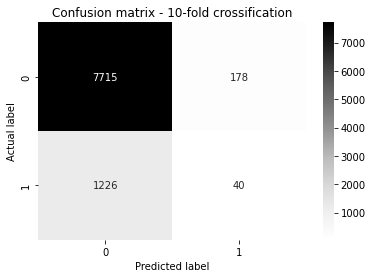

==================== Tomek ====================
number of features: 9
Tomek - XGBRF
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.54      0.95      0.69      7892
         1.0       0.78      0.18      0.30      7892

    accuracy                           0.57     15784
   macro avg       0.66      0.57      0.49     15784
weighted avg       0.66      0.57      0.49     15784



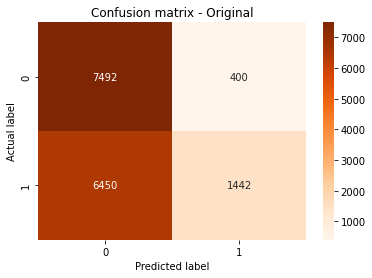

Kfold report:
               precision    recall  f1-score   support

         0.0       0.77      0.74      0.76      7892
         1.0       0.75      0.79      0.77      7892

    accuracy                           0.76     15784
   macro avg       0.76      0.76      0.76     15784
weighted avg       0.76      0.76      0.76     15784



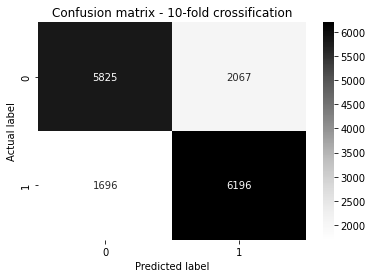

Tomek - Random Forest
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7892
         1.0       1.00      1.00      1.00      7892

    accuracy                           1.00     15784
   macro avg       1.00      1.00      1.00     15784
weighted avg       1.00      1.00      1.00     15784



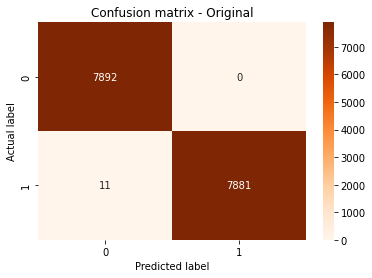

Kfold report:
               precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      7892
         1.0       0.93      0.91      0.92      7892

    accuracy                           0.92     15784
   macro avg       0.92      0.92      0.92     15784
weighted avg       0.92      0.92      0.92     15784



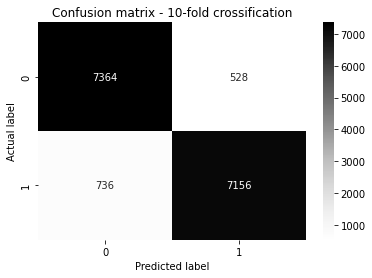

Tomek - Xgboost


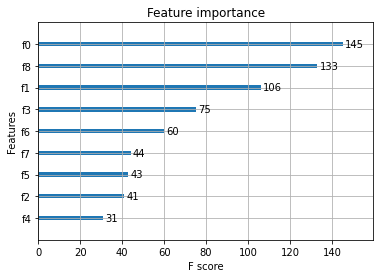

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.77      0.92      0.84      7892
         1.0       0.90      0.73      0.81      7892

    accuracy                           0.82     15784
   macro avg       0.84      0.82      0.82     15784
weighted avg       0.84      0.82      0.82     15784



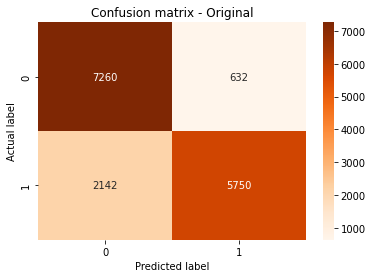

Kfold report:
               precision    recall  f1-score   support

         0.0       0.84      0.91      0.88      7892
         1.0       0.90      0.83      0.87      7892

    accuracy                           0.87     15784
   macro avg       0.87      0.87      0.87     15784
weighted avg       0.87      0.87      0.87     15784



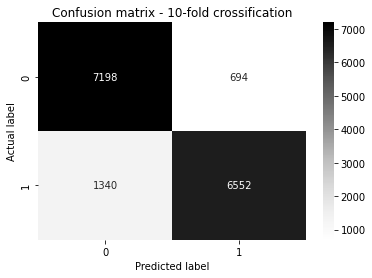

==================== Enn ====================
number of features: 16
Enn - XGBRF
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.52      0.96      0.67      7889
         1.0       0.71      0.11      0.19      7862

    accuracy                           0.53     15751
   macro avg       0.62      0.53      0.43     15751
weighted avg       0.61      0.53      0.43     15751



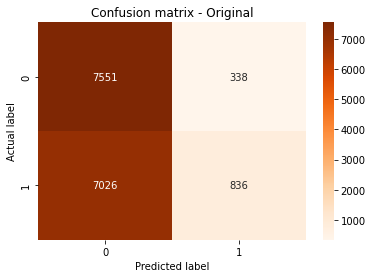

Kfold report:
               precision    recall  f1-score   support

         0.0       0.74      0.74      0.74      7889
         1.0       0.74      0.73      0.74      7862

    accuracy                           0.74     15751
   macro avg       0.74      0.74      0.74     15751
weighted avg       0.74      0.74      0.74     15751



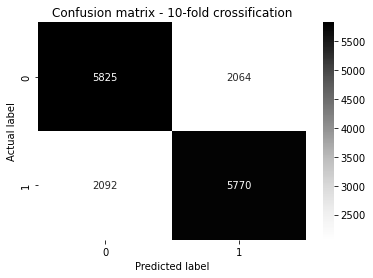

Enn - Random Forest
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      7889
         1.0       0.50      1.00      0.67      7862

    accuracy                           0.50     15751
   macro avg       0.25      0.50      0.33     15751
weighted avg       0.25      0.50      0.33     15751



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


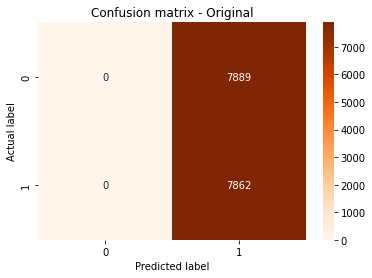

Kfold report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      7889
         1.0       0.94      0.97      0.96      7862

    accuracy                           0.96     15751
   macro avg       0.96      0.96      0.96     15751
weighted avg       0.96      0.96      0.96     15751



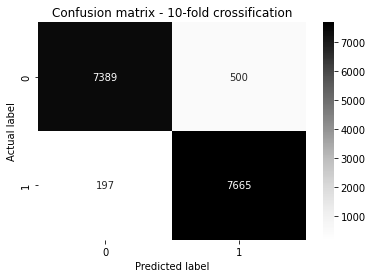

Enn - Xgboost


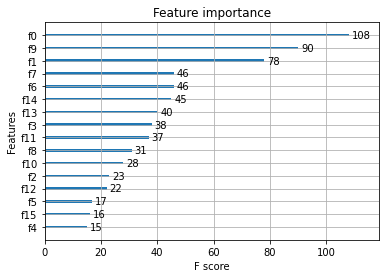

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.88      0.03      0.05      7889
         1.0       0.50      1.00      0.67      7862

    accuracy                           0.51     15751
   macro avg       0.69      0.51      0.36     15751
weighted avg       0.69      0.51      0.36     15751



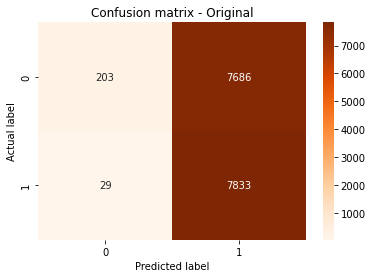

Kfold report:
               precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      7889
         1.0       0.87      0.87      0.87      7862

    accuracy                           0.87     15751
   macro avg       0.87      0.87      0.87     15751
weighted avg       0.87      0.87      0.87     15751



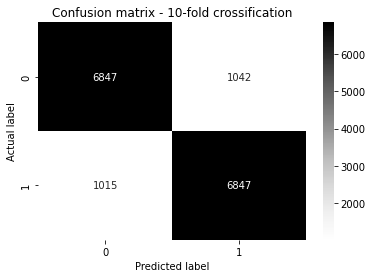

In [7]:
# Experiment A #########################################
print("="*20,'Raw', "="*20)
print("number of features:", len(data_filter_wraper_raw.columns)-1)
data = Scale(data_filter_wraper_raw)
X_train = data[0][:-len(raw_test)]
y_train = data[1][:-len(raw_test)]
X_test = data[0][-len(raw_test):]
y_test = data[1][-len(raw_test):]
print('Raw - XGBRF')
XGBRF_model = XGBRF(X_train, y_train)
model_evaluation(XGBRF_model, X_train, y_train, X_test, y_test)
print('Raw - Random Forest')
RF_model = forest(X_train, y_train)
model_evaluation(RF_model, X_train, y_train, X_test, y_test)
print("Raw - Xgboost")
Xgboost_model = Xgboost(X_train, y_train)
model_evaluation(Xgboost_model, X_train, y_train, X_test, y_test)

print("="*20,'Tomek', "="*20)
print("number of features:", len(data_filter_wrapper_Tomek.columns)-1)
data = Scale(data_filter_wrapper_Tomek)
X_train_Tomek = data[0][:-len(data_Tomek_test)]
y_train_Tomek = data[1][:-len(data_Tomek_test)]
X_test_Tomek = data[0][-len(data_Tomek_test):]
y_test_Tomek = data[1][-len(data_Tomek_test):]
print('Tomek - XGBRF')
XGBRF_model = XGBRF(X_train_Tomek, y_train_Tomek)
model_evaluation(XGBRF_model, X_train_Tomek, y_train_Tomek, X_test_Tomek, y_test_Tomek)
print('Tomek - Random Forest')
RF_model = forest(X_train_Tomek, y_train_Tomek)
model_evaluation(RF_model, X_train_Tomek, y_train_Tomek, X_test_Tomek, y_test_Tomek)
print("Tomek - Xgboost")
Xgboost_model = Xgboost(X_train_Tomek, y_train_Tomek)
model_evaluation(Xgboost_model, X_train_Tomek, y_train_Tomek, X_test_Tomek, y_test_Tomek)

print("="*20,'Enn', "="*20)
print("number of features:", len(data_filter_wrapper_Enn.columns)-1)
data = Scale(data_filter_wrapper_Enn)
X_train_Enn = data[0][:-len(data_Enn_test)]
y_train_Enn = data[1][:-len(data_Enn_test)]
X_test_Enn = data[0][-len(data_Enn_test):]
y_test_Enn = data[1][-len(data_Enn_test):]
print('Enn - XGBRF')
XGBRF_model = XGBRF(X_train_Enn, y_train_Enn)
model_evaluation(XGBRF_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)
print('Enn - Random Forest')
RF_model = forest(X_train_Enn, y_train_Enn)
model_evaluation(RF_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)
print("Enn - Xgboost")
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)
model_evaluation(Xgboost_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

==================== Raw ====================
Features: Index(['rssd_id', 'failure', 'size', 'deposit_assets', 'htminv_assets',
       'fsale_assets', 'lev', 'refarmcol_assets', 'loanagri_assets',
       'ciloan_assets', 'creditcard_assets', 'otherpploan_assets',
       'otherloan_assets', 'demanddep_assets', 'timedep_assets',
       'otherresidloan_assets', 'npl_assets', 'loanlossalwc', 'loanlossprov',
       'nim', 'nnon_im', 'roa', 'chargeoff_assets', 'secborrowed_obs',
       'seclent_obs', 'revolvelines_assets', 'creditcard_line_obs',
       'resid_recol_obs', 'resid_norecol_obs', 'underwriting_obs', 'tier1_car',
       'annual gdp', 'gdp growth', 'unemployment rate',
       'housing start(million)', 'consumer price index', 'rate of inflation',
       'date', 'month', 'year'],
      dtype='object')


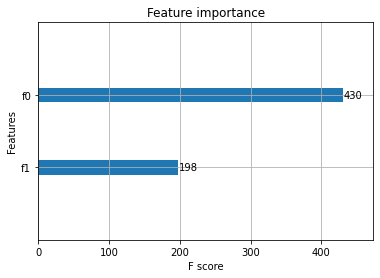

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.51      0.94      0.66      7889
         1.0       0.63      0.10      0.17      7862

    accuracy                           0.52     15751
   macro avg       0.57      0.52      0.42     15751
weighted avg       0.57      0.52      0.42     15751



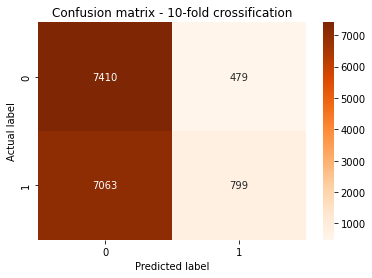

Kfold report:
               precision    recall  f1-score   support

         0.0       0.66      0.21      0.32      7889
         1.0       0.53      0.89      0.66      7862

    accuracy                           0.55     15751
   macro avg       0.59      0.55      0.49     15751
weighted avg       0.59      0.55      0.49     15751



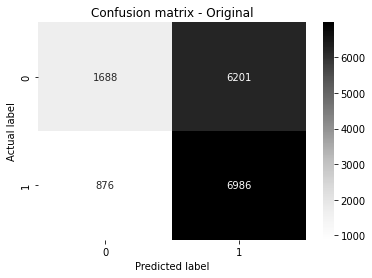

==================== Filter only ====================
Features: Index(['size', 'deposit_assets', 'fsale_assets', 'refarmcol_assets',
       'loanagri_assets', 'ciloan_assets', 'creditcard_assets',
       'otherpploan_assets', 'otherresidloan_assets', 'loanlossalwc',
       'loanlossprov', 'nnon_im', 'roa', 'chargeoff_assets', 'secborrowed_obs',
       'revolvelines_assets', 'resid_recol_obs', 'tier1_car', 'annual gdp',
       'gdp growth', 'unemployment rate', 'housing start(million)',
       'consumer price index', 'rate of inflation', 'year', 'failure'],
      dtype='object')


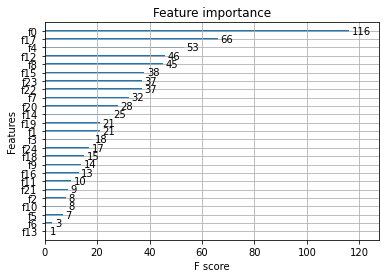

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.93      0.02      0.04      7889
         1.0       0.50      1.00      0.67      7862

    accuracy                           0.51     15751
   macro avg       0.72      0.51      0.35     15751
weighted avg       0.72      0.51      0.35     15751



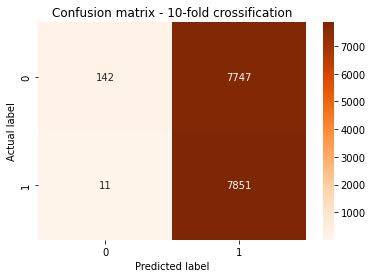

Kfold report:
               precision    recall  f1-score   support

         0.0       0.88      0.87      0.87      7889
         1.0       0.87      0.88      0.88      7862

    accuracy                           0.88     15751
   macro avg       0.88      0.88      0.88     15751
weighted avg       0.88      0.88      0.88     15751



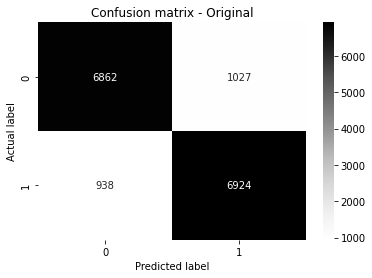

==================== Wrapper only ====================
Features: Index(['rssd_id', 'size', 'loanagri_assets', 'ciloan_assets',
       'otherpploan_assets', 'demanddep_assets', 'nnon_im', 'roa',
       'creditcard_line_obs', 'resid_recol_obs', 'underwriting_obs',
       'tier1_car', 'housing start(million)', 'month', 'failure'],
      dtype='object')


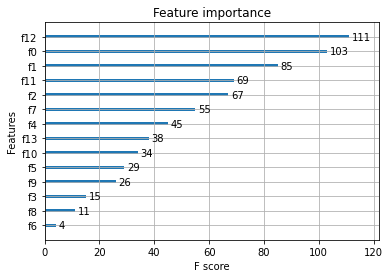

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.77      0.53      0.63      7889
         1.0       0.64      0.85      0.73      7862

    accuracy                           0.69     15751
   macro avg       0.71      0.69      0.68     15751
weighted avg       0.71      0.69      0.68     15751



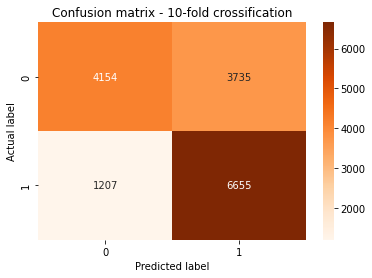

Kfold report:
               precision    recall  f1-score   support

         0.0       0.89      0.64      0.74      7889
         1.0       0.72      0.92      0.81      7862

    accuracy                           0.78     15751
   macro avg       0.80      0.78      0.77     15751
weighted avg       0.80      0.78      0.77     15751



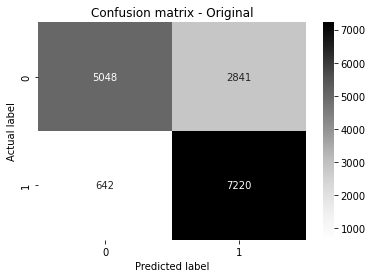

==================== Wrapper + Filter ====================
Features: Index(['size', 'loanagri_assets', 'ciloan_assets', 'loanlossalwc',
       'loanlossprov', 'nnon_im', 'roa', 'resid_recol_obs', 'tier1_car',
       'annual gdp', 'housing start(million)', 'consumer price index', 'year',
       'failure'],
      dtype='object')


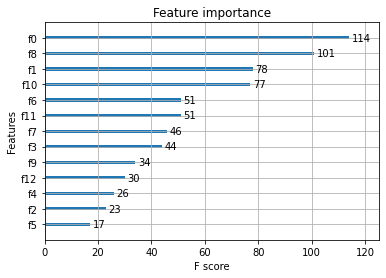

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      7889
         1.0       0.50      1.00      0.67      7862

    accuracy                           0.50     15751
   macro avg       0.25      0.50      0.33     15751
weighted avg       0.25      0.50      0.33     15751



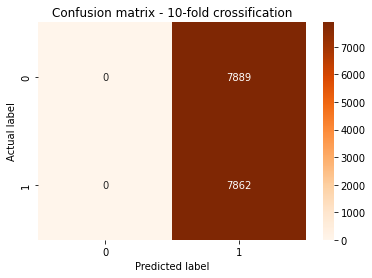

Kfold report:
               precision    recall  f1-score   support

         0.0       0.85      0.86      0.86      7889
         1.0       0.86      0.85      0.85      7862

    accuracy                           0.86     15751
   macro avg       0.86      0.86      0.86     15751
weighted avg       0.86      0.86      0.86     15751



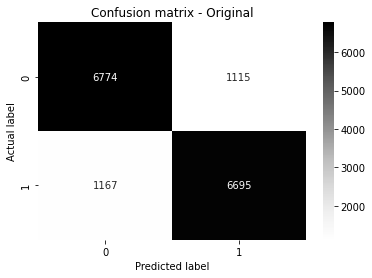

==================== Lasso only ====================
Training score (R²): 0.014760950277894813
Test score (R²): 0.014786880200018726
Mean Absolute Error: 0.4941404364070016
Mean Squared Error: 0.2463032364789768
Root Mean Squared Error: 0.4962894684344781


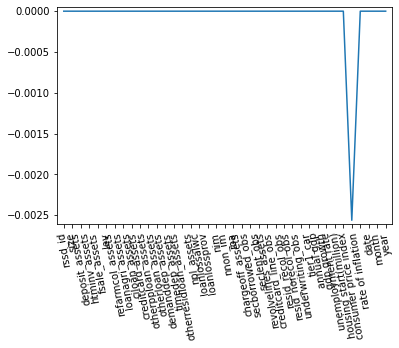

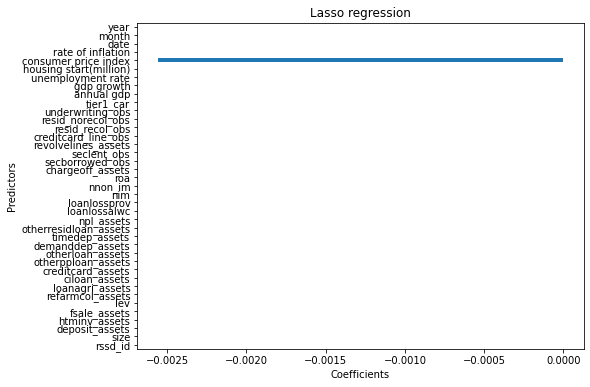

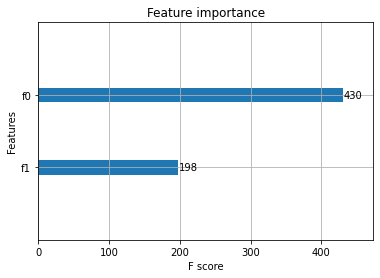

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.51      0.94      0.66      7889
         1.0       0.63      0.10      0.17      7862

    accuracy                           0.52     15751
   macro avg       0.57      0.52      0.42     15751
weighted avg       0.57      0.52      0.42     15751



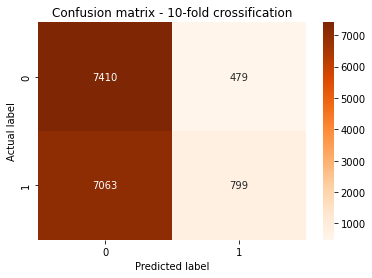

Kfold report:
               precision    recall  f1-score   support

         0.0       0.66      0.21      0.32      7889
         1.0       0.53      0.89      0.66      7862

    accuracy                           0.55     15751
   macro avg       0.59      0.55      0.49     15751
weighted avg       0.59      0.55      0.49     15751



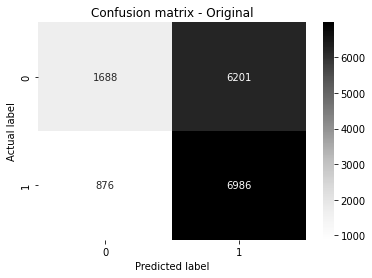

In [26]:
# Experiment B #########################################
## raw (without any feature selection method)
print("="*20,'Raw', "="*20)
print("Features:", raw.columns)
data = Scale(raw)
X_train = data[0][:-len(raw_test)]
y_train = data[1][:-len(raw_test)]
X_test = data[0][-len(raw_test):]
y_test = data[1][-len(raw_test):]
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)
model_evaluation(Xgboost_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

## Filter only
print("="*20,'Filter only', "="*20)
print("Features:", data_filter_Enn.columns)
data = Scale(data_filter_Enn)
X_train_Enn = data[0][:-len(data_Enn_test)]
y_train_Enn = data[1][:-len(data_Enn_test)]
X_test_Enn = data[0][-len(data_Enn_test):]
y_test_Enn = data[1][-len(data_Enn_test):]
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)
model_evaluation(Xgboost_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

## Wrapper only
print("="*20,'Wrapper only', "="*20)
print("Features:", data_wrapper_Enn.columns)
data = Scale(data_wrapper_Enn)
X_train_Enn = data[0][:-len(data_Enn_test)]
y_train_Enn = data[1][:-len(data_Enn_test)]
X_test_Enn = data[0][-len(data_Enn_test):]
y_test_Enn = data[1][-len(data_Enn_test):]
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)
model_evaluation(Xgboost_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

## Wrapper + Filter
print("="*20,'Wrapper + Filter', "="*20)
print("Features:", data_filter_wrapper_Enn.columns)
data = Scale(data_filter_wrapper_Enn)
X_train_Enn = data[0][:-len(data_Enn_test)]
y_train_Enn = data[1][:-len(data_Enn_test)]
X_test_Enn = data[0][-len(data_Enn_test):]
y_test_Enn = data[1][-len(data_Enn_test):]
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)
model_evaluation(Xgboost_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

## Lasso
print("="*20,'Lasso only', "="*20)
data = Scale(lasso(data_Enn))
X_train_Enn = data[0][:-len(data_Enn_test)]
y_train_Enn = data[1][:-len(data_Enn_test)]
X_test_Enn = data[0][-len(data_Enn_test):]
y_test_Enn = data[1][-len(data_Enn_test):]
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)
model_evaluation(Xgboost_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

==================== PCA only ====================


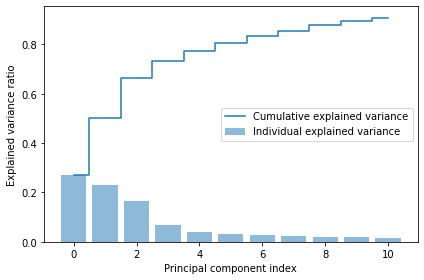

pca.components_ (11, 39)
pca_var_ratio (11,)


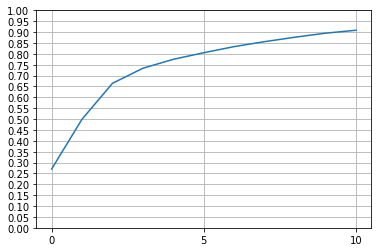

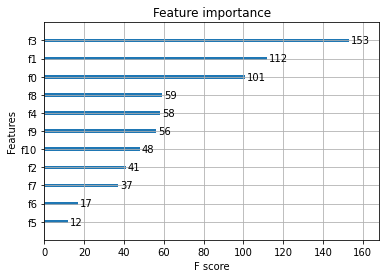

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.69      0.56      0.62      7889
         1.0       0.63      0.75      0.68      7862

    accuracy                           0.65     15751
   macro avg       0.66      0.65      0.65     15751
weighted avg       0.66      0.65      0.65     15751



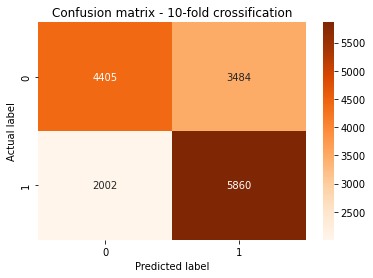

Kfold report:
               precision    recall  f1-score   support

         0.0       0.82      0.77      0.80      7889
         1.0       0.79      0.83      0.81      7862

    accuracy                           0.80     15751
   macro avg       0.80      0.80      0.80     15751
weighted avg       0.80      0.80      0.80     15751



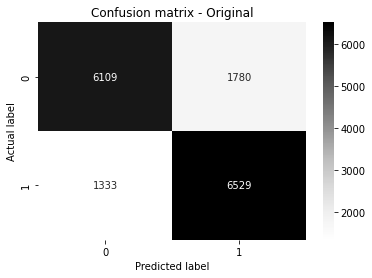

==================== Feature selection only ====================


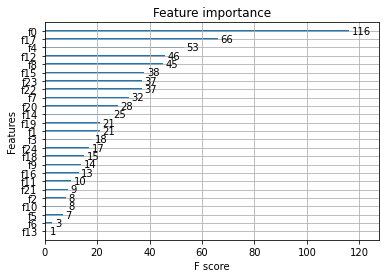

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.93      0.02      0.04      7889
         1.0       0.50      1.00      0.67      7862

    accuracy                           0.51     15751
   macro avg       0.72      0.51      0.35     15751
weighted avg       0.72      0.51      0.35     15751



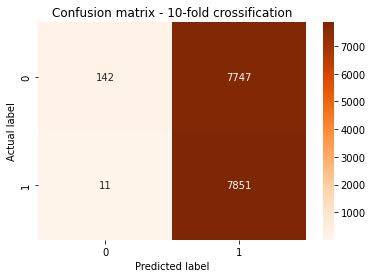

Kfold report:
               precision    recall  f1-score   support

         0.0       0.88      0.87      0.87      7889
         1.0       0.87      0.88      0.88      7862

    accuracy                           0.88     15751
   macro avg       0.88      0.88      0.88     15751
weighted avg       0.88      0.88      0.88     15751



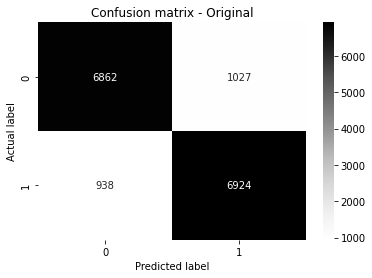

==================== Feature selection + PCA ====================


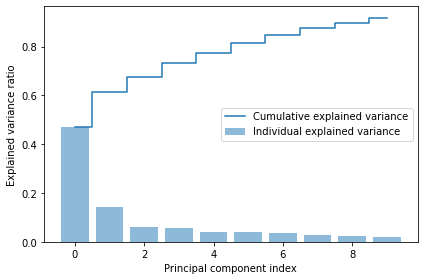

pca.components_ (10, 25)
pca_var_ratio (10,)


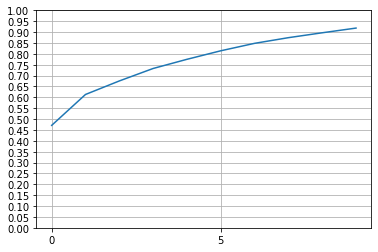

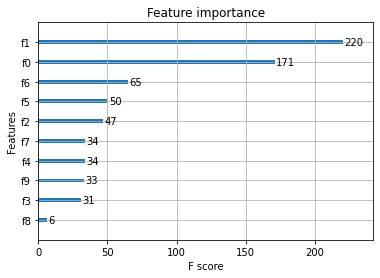

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.70      0.33      0.45      7889
         1.0       0.56      0.85      0.68      7862

    accuracy                           0.59     15751
   macro avg       0.63      0.59      0.56     15751
weighted avg       0.63      0.59      0.56     15751



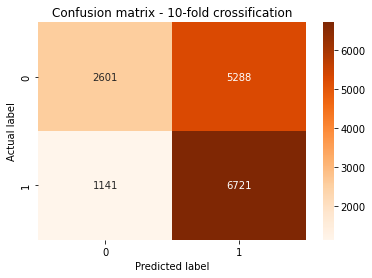

Kfold report:
               precision    recall  f1-score   support

         0.0       0.82      0.80      0.81      7889
         1.0       0.81      0.82      0.81      7862

    accuracy                           0.81     15751
   macro avg       0.81      0.81      0.81     15751
weighted avg       0.81      0.81      0.81     15751



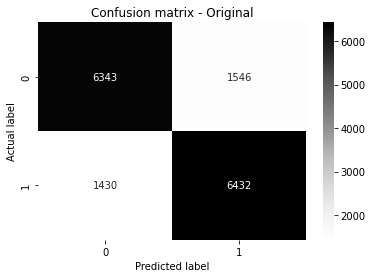

In [32]:
# Experiment C #########################################
## PCA only
print("="*20,'PCA only','='*20)
data = PCA_(Scale(data_Enn)[0],Scale(data_Enn)[1])
X_train_Enn = data[0][:-len(data_Enn_test)]
y_train_Enn = data[1][:-len(data_Enn_test)]
X_test_Enn = data[0][-len(data_Enn_test):]
y_test_Enn = data[1][-len(data_Enn_test):]
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)
model_evaluation(Xgboost_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

## Feature selection only
print("="*20,'Feature selection only','='*20)
data = Scale(data_filter_Enn)
X_train_Enn = data[0][:-len(data_Enn_test)]
y_train_Enn = data[1][:-len(data_Enn_test)]
X_test_Enn = data[0][-len(data_Enn_test):]
y_test_Enn = data[1][-len(data_Enn_test):]
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)
model_evaluation(Xgboost_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

## Feature selection + PCA
print("="*20,'Feature selection + PCA','='*20)
data = PCA_(Scale(data_filter_Enn)[0], Scale(data_filter_Enn)[1])
X_train_Enn = data[0][:-len(data_Enn_test)]
y_train_Enn = data[1][:-len(data_Enn_test)]
X_test_Enn = data[0][-len(data_Enn_test):]
y_test_Enn = data[1][-len(data_Enn_test):]
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)
model_evaluation(Xgboost_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

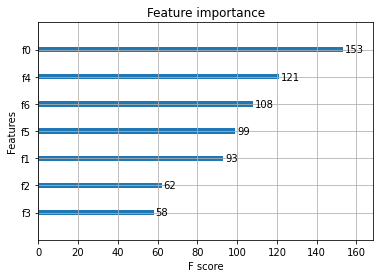

==================== XGBRF ====================
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.52      0.95      0.67      7889
         1.0       0.69      0.11      0.18      7862

    accuracy                           0.53     15751
   macro avg       0.61      0.53      0.43     15751
weighted avg       0.61      0.53      0.43     15751



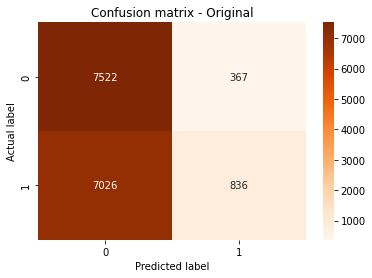

Kfold report:
               precision    recall  f1-score   support

         0.0       0.72      0.75      0.74      7889
         1.0       0.74      0.71      0.73      7862

    accuracy                           0.73     15751
   macro avg       0.73      0.73      0.73     15751
weighted avg       0.73      0.73      0.73     15751



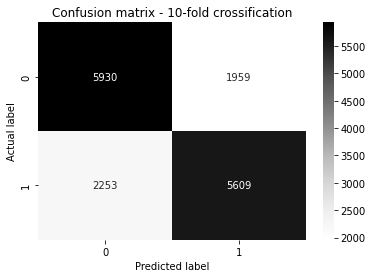

==================== Random Forest ====================
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.69      0.08      0.15      7889
         1.0       0.51      0.96      0.67      7862

    accuracy                           0.52     15751
   macro avg       0.60      0.52      0.41     15751
weighted avg       0.60      0.52      0.41     15751



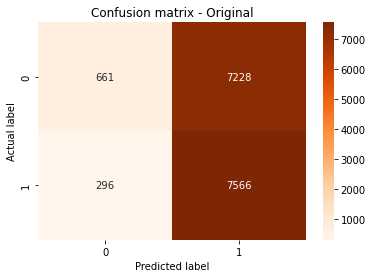

Kfold report:
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      7889
         1.0       0.92      0.97      0.94      7862

    accuracy                           0.94     15751
   macro avg       0.94      0.94      0.94     15751
weighted avg       0.94      0.94      0.94     15751



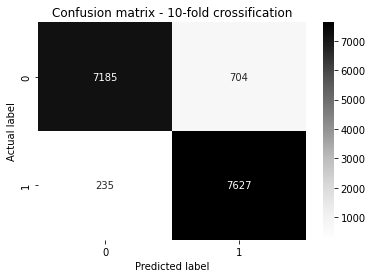

==================== XGBoost ====================


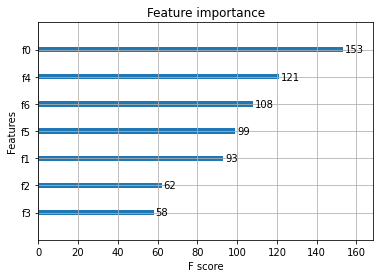

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.69      0.29      0.41      7889
         1.0       0.55      0.87      0.67      7862

    accuracy                           0.58     15751
   macro avg       0.62      0.58      0.54     15751
weighted avg       0.62      0.58      0.54     15751



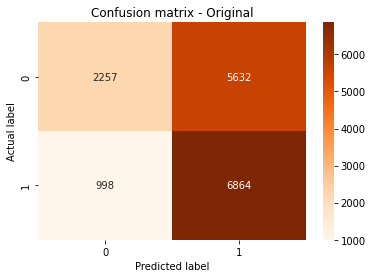

Kfold report:
               precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      7889
         1.0       0.83      0.85      0.84      7862

    accuracy                           0.84     15751
   macro avg       0.84      0.84      0.84     15751
weighted avg       0.84      0.84      0.84     15751



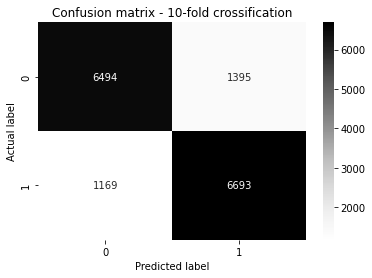

==================== Logistic Regression ====================
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.51      1.00      0.67      7889
         1.0       0.94      0.02      0.04      7862

    accuracy                           0.51     15751
   macro avg       0.72      0.51      0.36     15751
weighted avg       0.72      0.51      0.36     15751



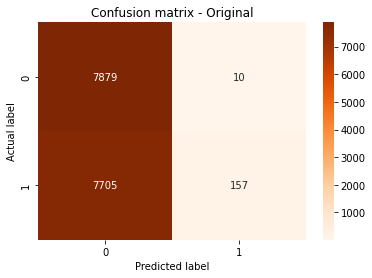

Kfold report:
               precision    recall  f1-score   support

         0.0       0.72      0.69      0.70      7889
         1.0       0.70      0.73      0.72      7862

    accuracy                           0.71     15751
   macro avg       0.71      0.71      0.71     15751
weighted avg       0.71      0.71      0.71     15751



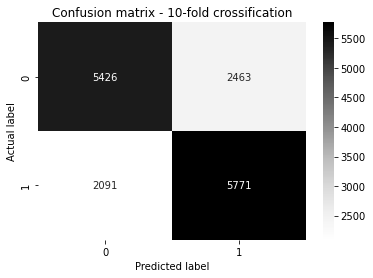

==================== KNN ====================
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.56      0.28      0.38      7889
         1.0       0.52      0.78      0.62      7862

    accuracy                           0.53     15751
   macro avg       0.54      0.53      0.50     15751
weighted avg       0.54      0.53      0.50     15751



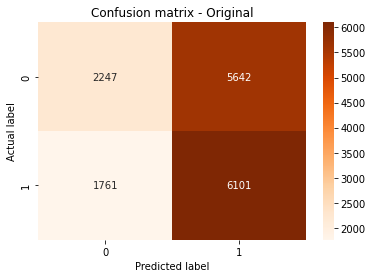

Kfold report:
               precision    recall  f1-score   support

         0.0       0.96      0.83      0.89      7889
         1.0       0.85      0.97      0.90      7862

    accuracy                           0.90     15751
   macro avg       0.90      0.90      0.90     15751
weighted avg       0.90      0.90      0.90     15751



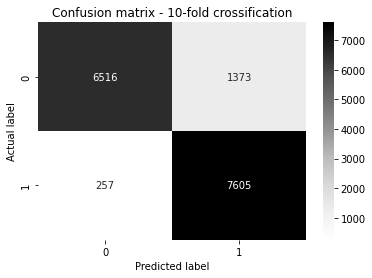

==================== Linear Regression ====================
[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      7889
         1.0       1.00      0.01      0.01      7862

    accuracy                           0.50     15751
   macro avg       0.75      0.50      0.34     15751
weighted avg       0.75      0.50      0.34     15751



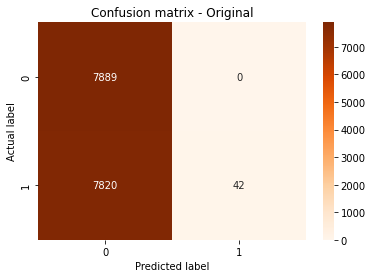

Kfold report:
               precision    recall  f1-score   support

         0.0       0.72      0.65      0.69      7889
         1.0       0.68      0.75      0.71      7862

    accuracy                           0.70     15751
   macro avg       0.70      0.70      0.70     15751
weighted avg       0.70      0.70      0.70     15751



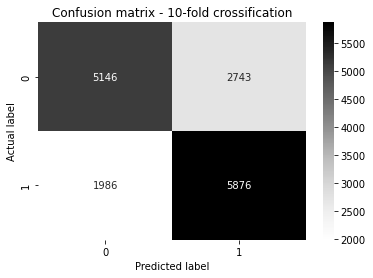

In [4]:
# Experiment D
print("="*20,'Raw', "="*20)
print("number of features:", len(data_filter_wraper_raw.columns)-1)
data = Scale(raw))
X_train = data[0][:-len(raw_test)]
y_train = data[1][:-len(raw_test)]
X_test = data[0][-len(raw_test):]
y_test = data[1][-len(raw_test):]
print('Raw - XGBRF')
XGBRF_model = XGBRF(X_train, y_train)
model_evaluation(XGBRF_model, X_train, y_train, X_test, y_test)
print('Raw - Random Forest')
RF_model = forest(X_train, y_train)
model_evaluation(RF_model, X_train, y_train, X_test, y_test)
print("Raw - Xgboost")
Xgboost_model = Xgboost(X_train, y_train)
model_evaluation(Xgboost_model, X_train, y_train, X_test, y_test)

data = Scale(data_filter_wrapper_Enn)
X_train_Enn = data[0][:-len(data_Enn_test)]
y_train_Enn = data[1][:-len(data_Enn_test)]
X_test_Enn = data[0][-len(data_Enn_test):]
y_test_Enn = data[1][-len(data_Enn_test):]
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)

print("="*20,'XGBRF','='*20)
XGBRF_model = XGBRF(X_train_Enn, y_train_Enn)
model_evaluation(XGBRF_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)
print("="*20,'Random Forest','='*20)
RF_model = forest(X_train_Enn, y_train_Enn)
model_evaluation(RF_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)
print("="*20,'XGBoost','='*20)
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)
model_evaluation(Xgboost_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)
## baselines
print("="*20,'Logistic Regression','='*20)
Logi_model = logisticRegression(X_train_Enn, y_train_Enn)
model_evaluation(Logi_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)
print("="*20,'KNN','='*20)
knn_model = knn_method(X_train_Enn, y_train_Enn)
model_evaluation(knn_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)
print("="*20,'Linear Regression','='*20)
lin_model = linearRegression(X_train_Enn, y_train_Enn)
model_evaluation(lin_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

[Confustion Matrix]
Original report:
               precision    recall  f1-score   support

         0.0       0.52      0.96      0.67      7889
         1.0       0.71      0.11      0.18      7862

    accuracy                           0.53     15751
   macro avg       0.61      0.53      0.43     15751
weighted avg       0.61      0.53      0.43     15751



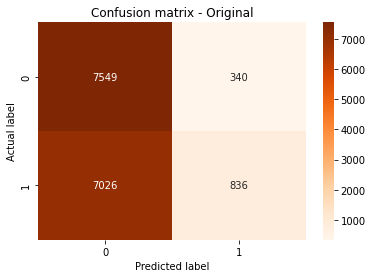

Kfold report:
               precision    recall  f1-score   support

         0.0       0.72      0.75      0.74      7889
         1.0       0.74      0.71      0.73      7862

    accuracy                           0.73     15751
   macro avg       0.73      0.73      0.73     15751
weighted avg       0.73      0.73      0.73     15751



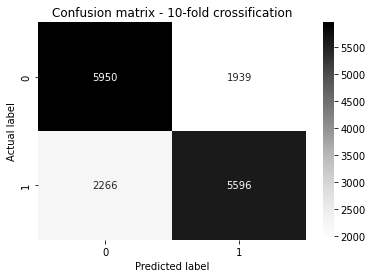

In [70]:
data = Scale(data_filter_wrapper_Enn)
X_train_Enn = data[0][:-len(data_Enn_test)]
y_train_Enn = data[1][:-len(data_Enn_test)]
X_test_Enn = data[0][-len(data_Enn_test):]
y_test_Enn = data[1][-len(data_Enn_test):]
Xgboost_model = Xgboost(X_train_Enn, y_train_Enn)

print("="*20,'XGBRF','='*20)
XGBRF_model = XGBRF(X_train_Enn, y_train_Enn)
model_evaluation(XGBRF_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)
print("="*20,'Random Forest','='*20)
RF_model = forest(X_train_Enn, y_train_Enn)
model_evaluation(RF_model, X_train_Enn, y_train_Enn, X_test_Enn, y_test_Enn)

## XAI

Random Forest

In [69]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_Enn),
    feature_names=data_filter_wrapper_Enn.columns,
    class_names=['success', 'failure'],
    mode='classification'
)
exp = explainer.explain_instance(
    data_row=pd.DataFrame(X_test_Enn).iloc[210], 
    predict_fn=XGBRF_model.predict_proba
)

exp.show_in_notebook(show_table=True)

In [ ]:
!pip install lime
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_Enn),
    feature_names=data_filter_wrapper_Enn.columns,
    class_names=['success', 'failure'],
    mode='classification'
)

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cross_val_predict(RF_model, X_test_Enn, y_test_Enn, cv=10,method='predict_proba')
exp = explainer.explain_instance(
    data_row=pd.DataFrame(X_test_Enn).iloc[210], 
    predict_fn=lambda x: (cross_val_predict(RF_model, X_test_Enn, y_test_Enn, cv=10,method='predict_proba')\
        .astype(float))[data_Enn_test.loc[(data_Enn_test['rssd_id']==x[0]) & (data_Enn_test['size']==x[1])].index[0]]
)
exp = explainer.explain_instance(
    data_row=pd.DataFrame(X_test_Enn).iloc[210], 
    predict_fn = lambda x: RF_model.predict_proba(x).astype(float)
)
n = lambda x: RF_model.predict_proba(x).astype(float)
n([data[0][0],1])
a = lambda x: ans[find(x)]
ans = cross_val_predict(RF_model, X_test_Enn, y_test_Enn, cv=10,method='predict_proba')
def find(x):
  for i in len(X_test_Enn):
    if X_test_Enn[0]==x[0] and X_test_Enn[1]==x[1]:
      return i
a([data[0][0],data[0][1]])
X_test_Enn
data_Enn_test.iloc[2][0]
def find(x):
 data_Enn_test[data_Enn_test['rssd_id']==x[0] and data_Enn_test['size']==x[1]].index()
exp.show_in_notebook(show_table=True)

In [148]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_Enn),
    feature_names=data_filter_wrapper_Enn.columns,
    class_names=['success', 'failure'],
    mode='classification'
)
exp = explainer.explain_instance(
    data_row=pd.DataFrame(X_test_Enn).iloc[1344], 
    predict_fn=RF_model.predict_proba
)

exp.show_in_notebook(show_table=True)